## Overview  

In this project I am working with data from Zillow to try to predict sales prices in the future. The goal is to see which zipcodes would make the most sense to invest in with regards to profit and return on investment.  

I will look at all three of these parameters when making my recommendations for these reasons: 
  
**Profit** - Tells us in dollar amount how much we estimate can be made as well as confidence intervels with a min and max profit margin.  
  
**Return on investment** - Percentage that can be gained, this metric can tell us if the amount we are able to make is a small or big precentage. This will help with understanding that even if a big profit can be made, this may be more of a risk with regards to small market swings. 

  
### City  

I will be looking at zipcodes in Kings County, NY, of which there are 28 zipcodes. 

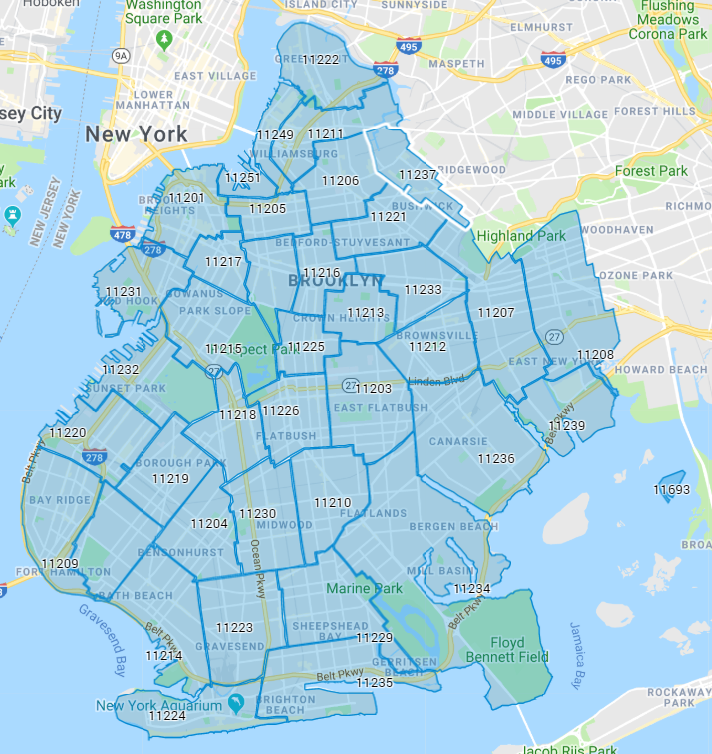

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from sklearn.metrics import mean_squared_error
import folium
from tqdm import tqdm

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [4]:
df1 = df.loc[(df['CountyName'] == 'Kings') & (df['State'] == 'NY')]

In [5]:
df1.head()

RegionID  RegionName      City State     Metro CountyName  SizeRank  \
10     62037       11226  New York    NY  New York      Kings        11   
13     62045       11235  New York    NY  New York      Kings        14   
47     62040       11230  New York    NY  New York      Kings        48   
49     62020       11209  New York    NY  New York      Kings        50   
53     62023       11212  New York    NY  New York      Kings        54   

     1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  2017-10  \
10  162000.0  162300.0  162600.0   ...      860200   851000   853900   870000   
13  190500.0  191000.0  191500.0   ...      767300   777300   788800   793900   
47  230100.0  230800.0  231500.0   ...     1079200  1082700  1082800  1084900   
49  255700.0  256600.0  257300.0   ...     1005000  1013400  1019500  1024400   
53  125000.0  125000.0  125000.0   ...      380000   387000   394600   401500   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
10   885100   887800   890500   901700   930700   963200  
13   796000   799700   806600   810600   813400   816200  
47  1091200  1102400  1120200  1141600  1170000  1195400  
49  1024900  1018900  1023500  1029200  1023000  1015800  
53   407900   414900   422300   426300   427100   428400  

[5 rows x 272 columns]

In [6]:
len(df1)

28

Checking for Null values

In [7]:
df1.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
1996-04       3
1996-05       3
1996-06       3
1996-07       3
1996-08       3
1996-09       3
1996-10       3
1996-11       3
1996-12       3
1997-01       3
1997-02       3
1997-03       3
1997-04       3
1997-05       3
1997-06       3
1997-07       3
1997-08       3
1997-09       3
1997-10       3
1997-11       3
1997-12       3
1998-01       3
1998-02       3
             ..
2015-11       0
2015-12       0
2016-01       0
2016-02       0
2016-03       0
2016-04       0
2016-05       0
2016-06       0
2016-07       0
2016-08       0
2016-09       0
2016-10       0
2016-11       0
2016-12       0
2017-01       0
2017-02       0
2017-03       0
2017-04       0
2017-05       0
2017-06       0
2017-07       0
2017-08       0
2017-09       0
2017-10       0
2017-11       0
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int6

Checking to see where those null values are

In [8]:
df1

RegionID  RegionName      City State     Metro CountyName  SizeRank  \
10       62037       11226  New York    NY  New York      Kings        11   
13       62045       11235  New York    NY  New York      Kings        14   
47       62040       11230  New York    NY  New York      Kings        48   
49       62020       11209  New York    NY  New York      Kings        50   
53       62023       11212  New York    NY  New York      Kings        54   
58       62025       11214  New York    NY  New York      Kings        59   
70       62032       11221  New York    NY  New York      Kings        71   
72       62039       11229  New York    NY  New York      Kings        73   
95       62044       11234  New York    NY  New York      Kings        96   
106      62026       11215  New York    NY  New York      Kings       107   
117      62022       11211  New York    NY  New York      Kings       118   
156      62048       11238  New York    NY  New York      Kings       157   
190      62043       11233  New York    NY  New York      Kings       191   
200      62046       11236  New York    NY  New York      Kings       201   
260      62029       11218  New York    NY  New York      Kings       261   
265      62034       11223  New York    NY  New York      Kings       266   
308      62019       11208  New York    NY  New York      Kings       309   
356      62015       11204  New York    NY  New York      Kings       357   
366      62030       11219  New York    NY  New York      Kings       367   
423      62014       11203  New York    NY  New York      Kings       424   
439      62031       11220  New York    NY  New York      Kings       440   
475      62027       11216  New York    NY  New York      Kings       476   
700      62021       11210  New York    NY  New York      Kings       701   
811      62035       11224  New York    NY  New York      Kings       812   
1155     62033       11222  New York    NY  New York      Kings      1156   
1434     62016       11205  New York    NY  New York      Kings      1435   
1534     62028       11217  New York    NY  New York      Kings      1535   
3728     62038       11228  New York    NY  New York      Kings      3729   

       1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
10    162000.0  162300.0  162600.0   ...      860200   851000   853900   
13    190500.0  191000.0  191500.0   ...      767300   777300   788800   
47    230100.0  230800.0  231500.0   ...     1079200  1082700  1082800   
49    255700.0  256600.0  257300.0   ...     1005000  1013400  1019500   
53    125000.0  125000.0  125000.0   ...      380000   387000   394600   
58    191000.0  191200.0  191500.0   ...      798000   805700   814200   
70    133700.0  133700.0  133700.0   ...      944500   948200   965300   
72    183900.0  184200.0  184500.0   ...      724100   730300   734500   
95    172300.0  172100.0  171900.0   ...      559400   563800   566400   
106   225700.0  227500.0  229400.0   ...     2173600  2201100  2244400   
117   133200.0  132900.0  132500.0   ...     1405100  1406400  1424700   
156        NaN       NaN       NaN   ...     2673300  2696700  2716500   
190   124500.0  124500.0  124500.0   ...      788800   788000   787100   
200   160900.0  161000.0  161200.0   ...      429500   434900   440900   
260   177200.0  177000.0  176800.0   ...     1201800  1195800  1199700   
265   207600.0  208000.0  208400.0   ...      924500   930000   935800   
308   126800.0  126700.0  126700.0   ...      432900   434400   437800   
356   201100.0  201100.0  201100.0   ...      921200   932800   946200   
366   213200.0  212600.0  211900.0   ...     1068200  1053000  1045400   
423   149000.0  149200.0  149400.0   ...      450900   454600   458800   
439   188500.0  188700.0  188800.0   ...      893000   906100   918500   
475   146100.0  146600.0  147200.0   ...     1452000  1506100  1553100   
700   187300.0  187300.0  187200.0   ...      777600   785800   792000

Seeing where these zipcode actually start, as I will need to filter for that in the modeling later

In [9]:
df1.loc[(df1['RegionName'] == 11238) | (df1['RegionName'] == 11205) | (df1['RegionName'] == 11217)].iloc[:, 95:]

2003-08  2003-09  2003-10  2003-11  2003-12    2004-01    2004-02  \
156       NaN      NaN      NaN      NaN      NaN   671200.0   665400.0   
1434      NaN      NaN      NaN      NaN      NaN   833100.0   821400.0   
1534      NaN      NaN      NaN      NaN      NaN  1037600.0  1035300.0   

        2004-03    2004-04    2004-05   ...     2017-07  2017-08  2017-09  \
156    662500.0   660200.0   659200.0   ...     2673300  2696700  2716500   
1434   812000.0   805500.0   801400.0   ...     2267400  2230800  2226800   
1534  1031400.0  1024000.0  1014300.0   ...     3405900  3442900  3443800   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
156   2724000  2744300  2768900  2810700  2848100  2869600  2885300  
1434  2241400  2248400  2251000  2251600  2245300  2243700  2248400  
1534  3426000  3407000  3404100  3413800  3482900  3588100  3656000  

[3 rows x 177 columns]

# Step 2: Reshape from Wide to Long Format

In [10]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [11]:
def melt_df(df):
    merged = []
    for zipcode in df.RegionName:
        melted = melt_data(df.loc[df['RegionName'] == zipcode])
        row = df.loc[df['RegionName'] == zipcode].iloc[:,:7]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [12]:
melted_df1 = melt_df(df1)

In [13]:
melted_df1.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64

In [14]:
melted_df1.head()

RegionID  RegionName      City State     Metro CountyName  SizeRank  \
0     62037       11226  New York    NY  New York      Kings        11   
1     62037       11226  New York    NY  New York      Kings        11   
2     62037       11226  New York    NY  New York      Kings        11   
3     62037       11226  New York    NY  New York      Kings        11   
4     62037       11226  New York    NY  New York      Kings        11   

        time     value  
0 1996-04-01  162000.0  
1 1996-05-01  162300.0  
2 1996-06-01  162600.0  
3 1996-07-01  163000.0  
4 1996-08-01  163400.0

In [15]:
len(melted_df1)

7141

Set the time column as the index

In [16]:
melted_df1.set_index('time', inplace=True)

# Step 3: EDA and Visualization

In [17]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# NOTE: if your visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Making a general visual, just to see the general trend of all the zipcodes

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


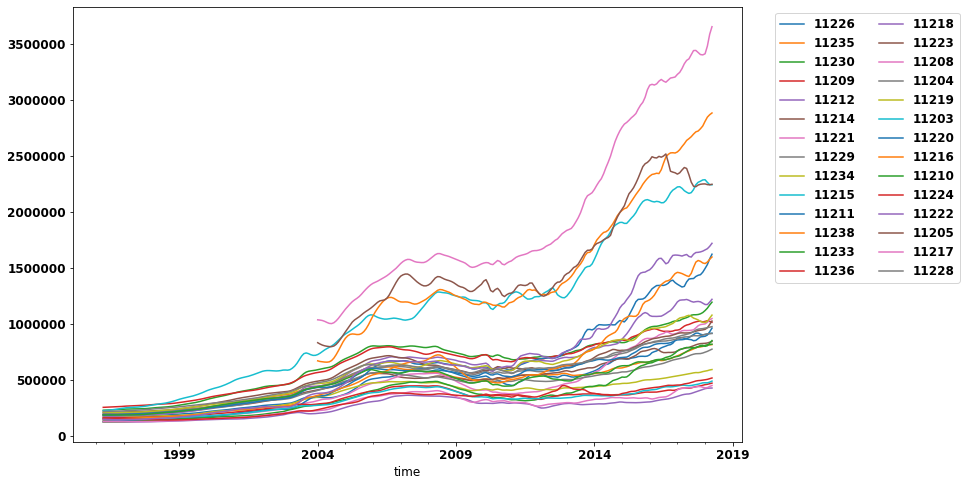

In [18]:
plt.figure(figsize=(12,8))
for zipcode in melted_df1.RegionName.unique():
    melted_df1.loc[melted_df1['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show()
    

I want to checkout the upper part of this graph as the lower part seems to not have much change from the start to the end. As it seems that the ones that have the most change start higher as well, I will just filter for the 10 best means and that should give me what I am looking for.

In [19]:
zips = pd.DataFrame()
zipsdict = {}
for zipcode in melted_df1.RegionName.unique():
    zipsdict[zipcode] = melted_df1.loc[melted_df1['RegionName'] == zipcode].value.mean()
zips['zipcode'] = zipsdict.keys()
zips['means'] = zipsdict.values()
highmean_list = list(zips.sort_values(by='means', ascending=False).zipcode[:10])

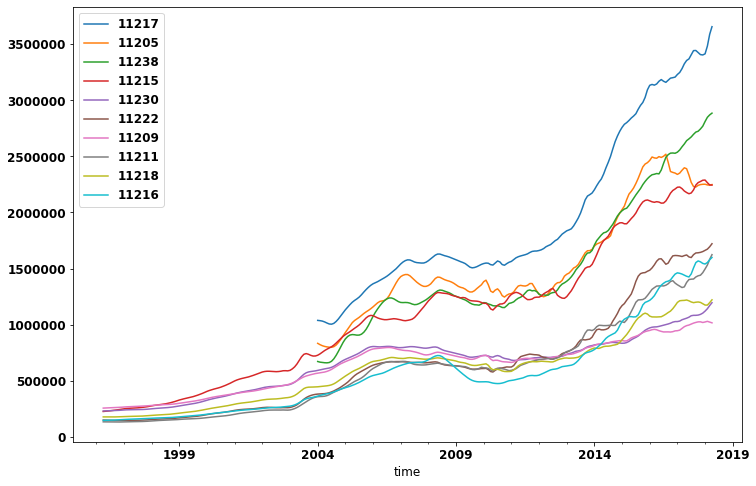

In [20]:
plt.figure(figsize=(12,8))
for zipcode in highmean_list:
    zipdf = melted_df1.loc[melted_df1['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.legend()
plt.show()

Seems I got what I am looking for, from 1996 until 2019, these seem to be the most growing zipcodes, though what effect that will have on future growth remains to be seen. Might be interesting to check back at this after I figure out the best ones by predictionto see if they match up or not

Just want to see a basic breakdown of one zipcode to see the seasonality and trends.

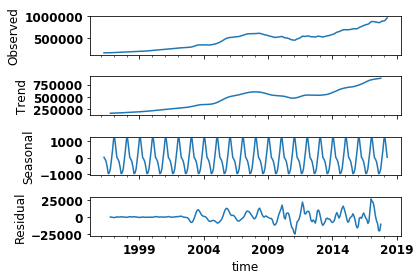

In [21]:
decomposition = seasonal_decompose(melted_df1.loc[melted_df1['RegionName'] == 11226].value)
decomposition.plot();

Seems to be very seasonal and the residuals seem to be more volatile from the start of the corresponding drop in the main graph, which seems to relate to the market crash. Though the drops here seem to be less, it seems the market crash did not affect Kings County in NY much

# Step 4: ARIMA Modeling

Making a test on one zipcode to then use the code for everything

In [22]:
test = melted_df1.loc[melted_df1['RegionName'] == 11226]

In [23]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(test.value,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
display(output.summary().tables[0], output.summary().tables[1], output.summary().tables[2])

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.table.SimpleTable'>

<class 'statsmodels.iolib.table.SimpleTable'>

<class 'statsmodels.iolib.table.SimpleTable'>

Printing the diagnostics of the model

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


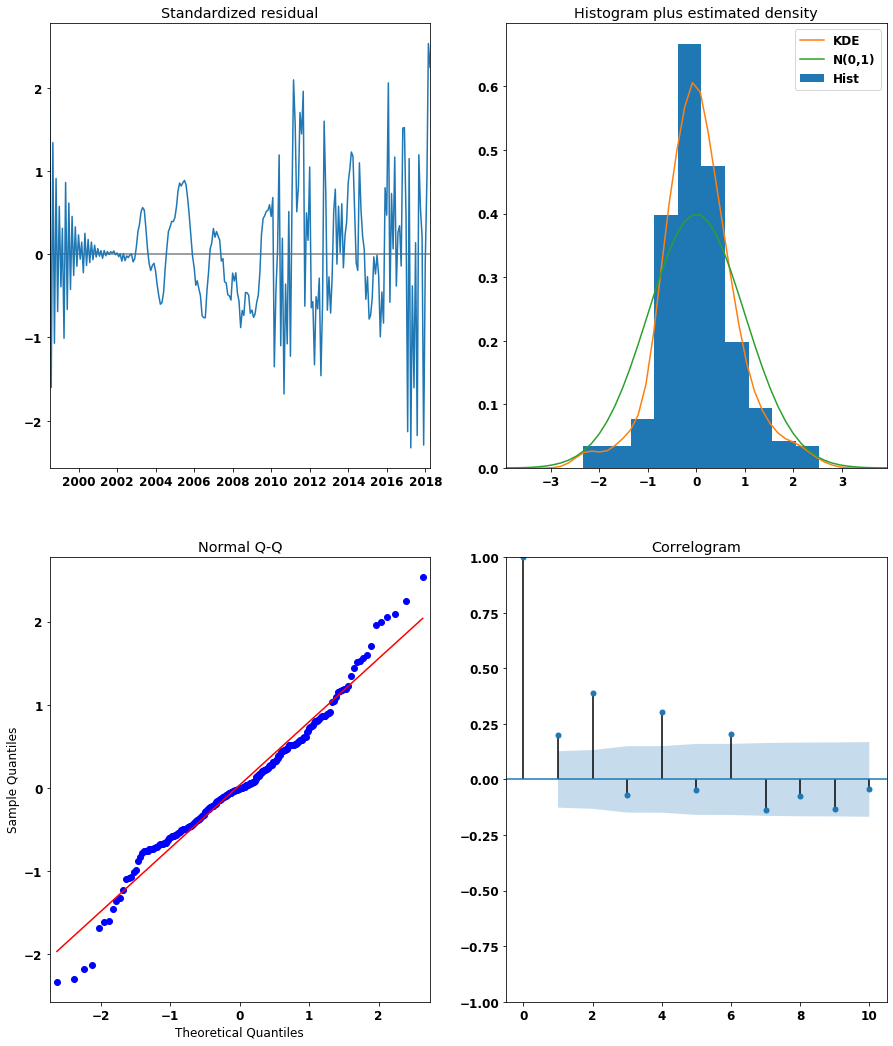

In [24]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

Checking getting the predictions along with the lower and upper confidence intervals

In [25]:
pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [26]:
b = {}
b['a'] = pred_conf[pred_conf.index == '2015-02-01']['lower value'][0]

In [27]:
pred_conf[pred_conf.index == '2015-02-01']['lower value']

2015-02-01    679750.731472
Freq: MS, Name: lower value, dtype: float64

In [28]:
b

{'a': 679750.7314722928}

In [29]:
pred_conf['upper value'].mean()

815026.6301956907

In [30]:
pred.predicted_mean['2018-01-01']

891075.7743019757

Making a graph of the predictions and the original data

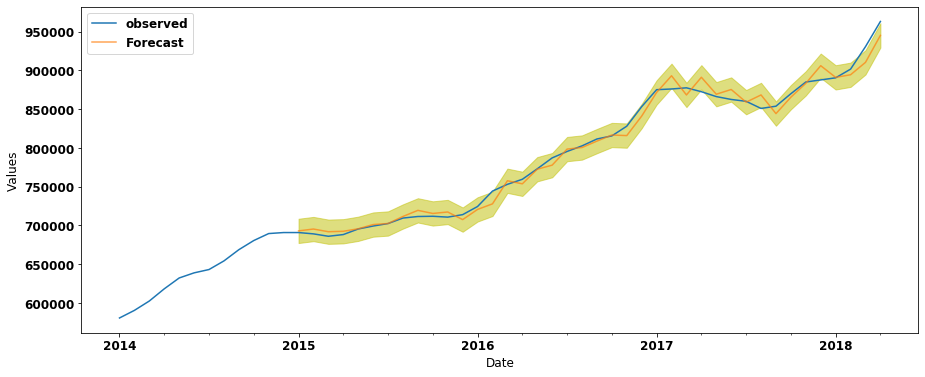

In [31]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = test['2014':].value.plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()

plt.show()

Checking the RMSE

In [32]:
test_forecasted = pred.predicted_mean
test_truth = test['2017':].value
test_forecasted = test_forecasted['2017':]
# Compute the root mean square error
error = mean_squared_error(test_forecasted, test_truth)
error = np.sqrt(error)
print(f'The RMSE of our forecasts is {error}')

The RMSE of our forecasts is 12375.014381008457


In [33]:
test_truth[-1]

963200.0

Our predictions are within about 12,375 dollars. Meaning about give or take 6,000 dollars. This is not too bad concidering that this zipcode has houses worth in the upper hundreds of thousands

I would like to figure out the best parameters to use for the model, based on AIC.  
First I will generate the possible combinations and then get the best one for each zipcode

In [34]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [35]:
best_combs = []
for zipcode in tqdm(melted_df1.RegionName.unique()):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(melted_df1.loc[melted_df1['RegionName'] == zipcode].value,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([zipcode, comb, combs, output.aic])
    #             print(f'ARIMA {comb} x {combs}12 : AIC Calculated ={output.aic}')
            except:
                continue
    best_combs.append(sorted(ans, key=lambda x: x[3])[0])

  0%|          | 0/28 [00:00<?, ?it/s]C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed 

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
 25%|██▌       | 7/28 [02:01<06:11, 17.67s/it]C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: Value

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
 50%|█████     | 14/28 [04:09<04:16, 18.33s/it]C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: Valu

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed 

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed 

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
100%|██████████| 28/28 [08:32<00:00, 18.16s/it]


In [36]:
best_combs

[[11226, (1, 1, 1), (1, 1, 1, 12), 4714.876675353281],
 [11235, (1, 1, 1), (1, 1, 1, 12), 4312.2381998360925],
 [11230, (1, 1, 1), (1, 1, 1, 12), 4485.037253656665],
 [11209, (1, 1, 1), (1, 1, 1, 12), 4585.73578636214],
 [11212, (1, 1, 1), (1, 1, 1, 12), 4021.2058447157933],
 [11214, (1, 1, 1), (0, 1, 1, 12), 4346.326118271097],
 [11221, (1, 1, 1), (1, 1, 1, 12), 4494.208580118686],
 [11229, (1, 1, 1), (1, 1, 1, 12), 4172.55546765251],
 [11234, (1, 1, 1), (1, 1, 1, 12), 4144.538560363072],
 [11215, (1, 1, 1), (1, 1, 1, 12), 4954.014040415874],
 [11211, (1, 1, 1), (1, 1, 1, 12), 4927.209337089314],
 [11238, (1, 1, 1), (1, 1, 1, 12), 3124.3992032066176],
 [11233, (1, 1, 1), (1, 1, 1, 12), 4533.147251268429],
 [11236, (1, 1, 1), (1, 1, 1, 12), 4150.027063049421],
 [11218, (1, 1, 1), (1, 1, 1, 12), 4715.717149957416],
 [11223, (1, 1, 1), (0, 1, 1, 12), 4480.865957904145],
 [11208, (1, 1, 1), (1, 1, 1, 12), 4250.901034399569],
 [11204, (1, 1, 1), (0, 1, 1, 12), 4286.6028645546085],
 [11219,

These are the best combinations for each zipcode, using 12 for seasonality and a 0 or a 1 for everything else.  

Make a function for creating an image with the original data, and the predicted data, along with the forcasted data and the confidence intervals

In [37]:
def make_pred_image(df, test_forecasted, forcast, zipcode=None):
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = df['2015':].plot(label='observed')

    #Plot predicted values
    test_forecasted['2015-01-01':].plot(ax=ax, label='Predicted', alpha=.7)
    
    forcast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
#     ax.title(zipcode)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    plt.legend()

    plt.show()
    return None

I am using a loop to get predictions for each zipcode based on the best combinations of parameters.  
It will also print out a graph for each zipcode along with the diagnostics.  
I put all the metrics I want into dictionaries with the zipcode as the key and the metric as the value.  
I also setup a dataframe and then make each dictionary correspond to a column in the dataframe

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11226


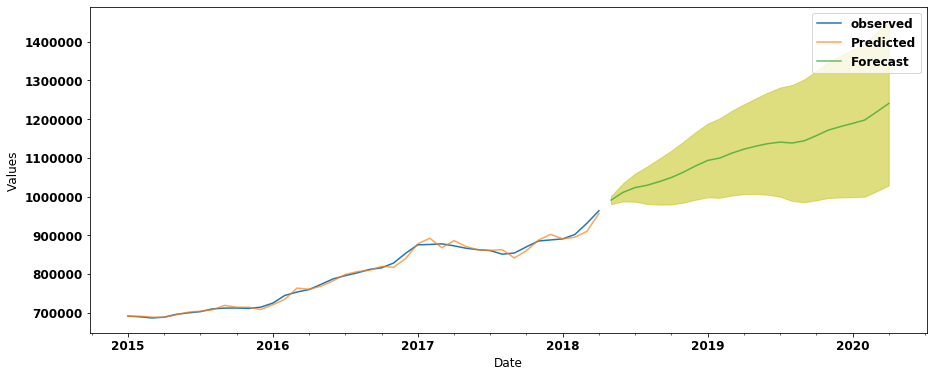

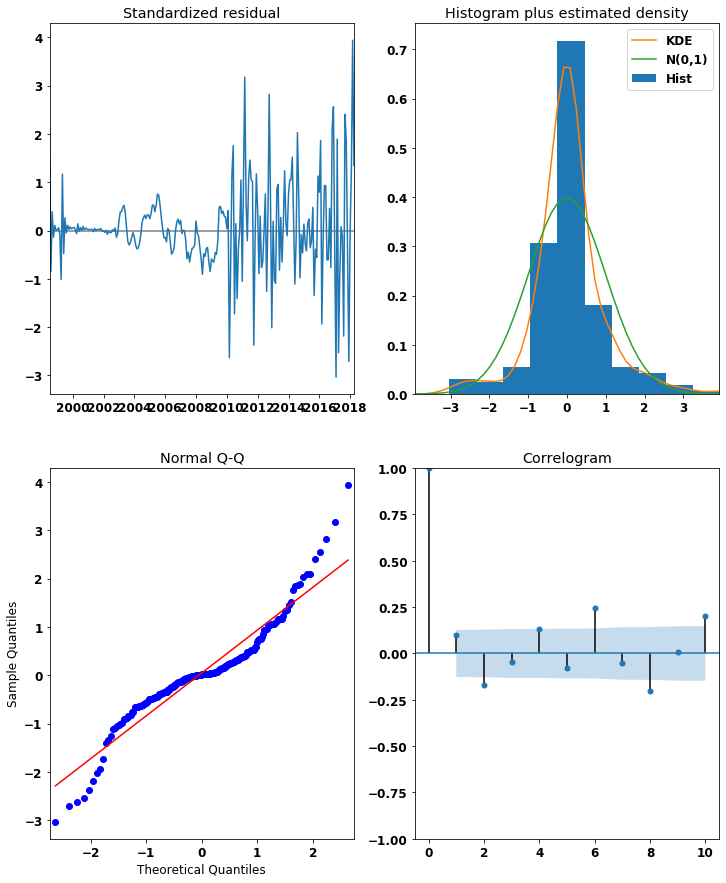

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11235


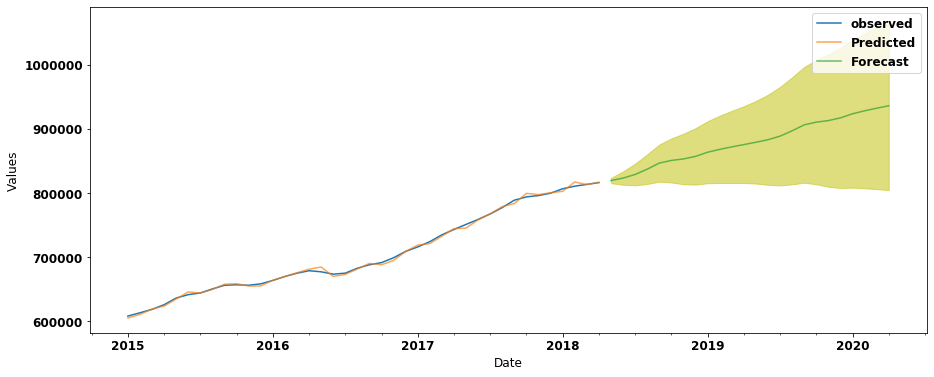

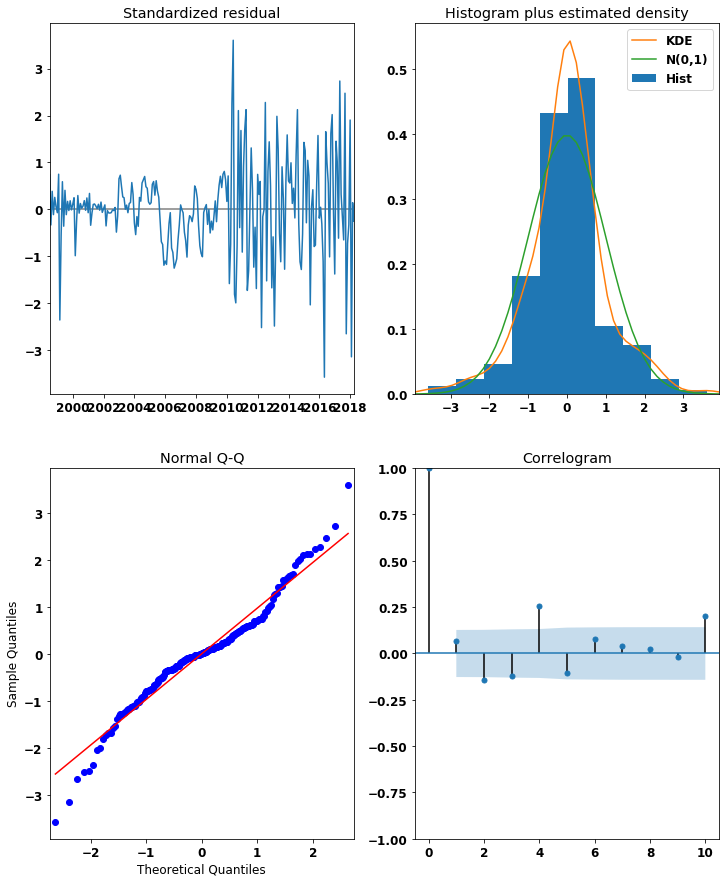

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11230


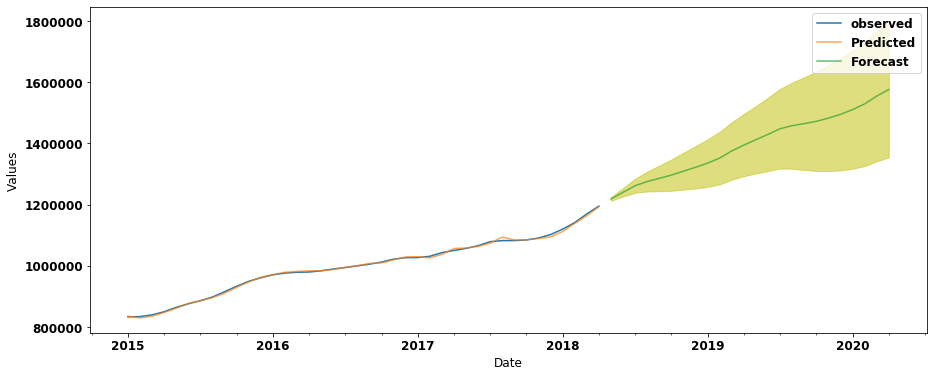

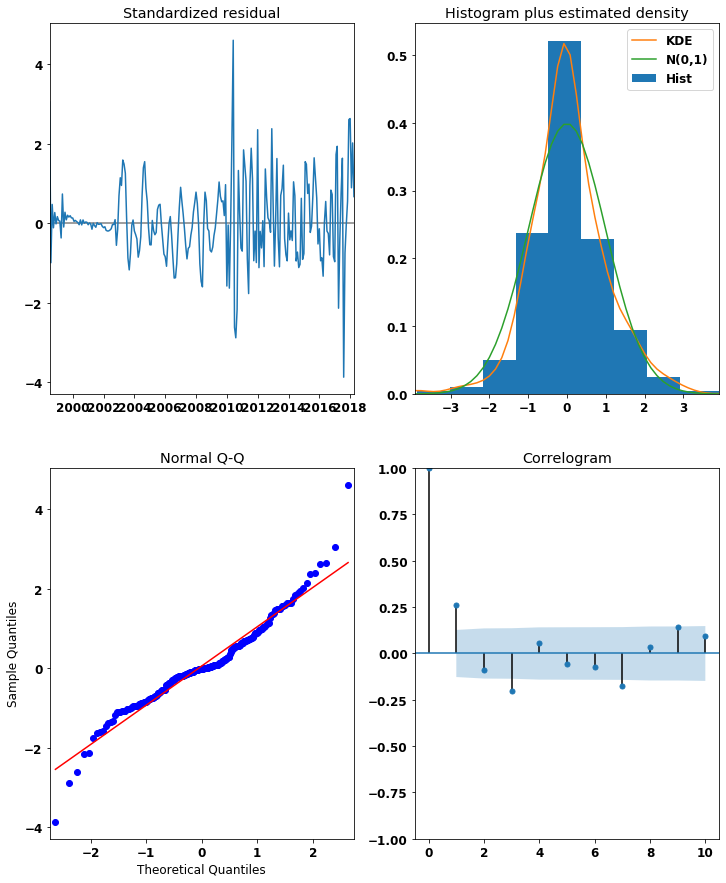

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11209


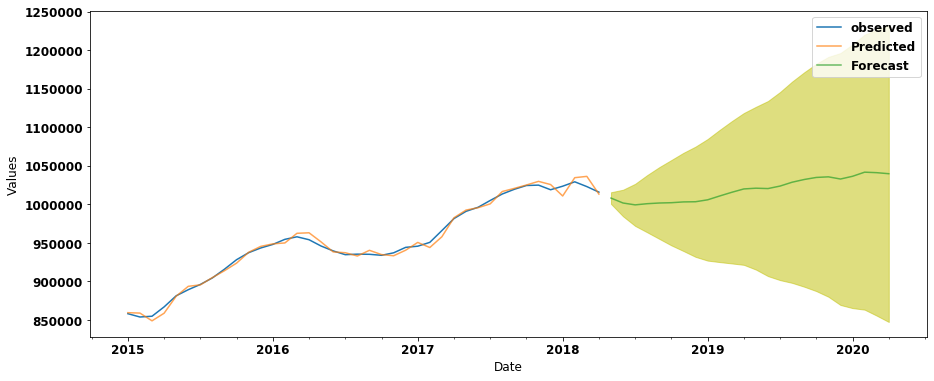

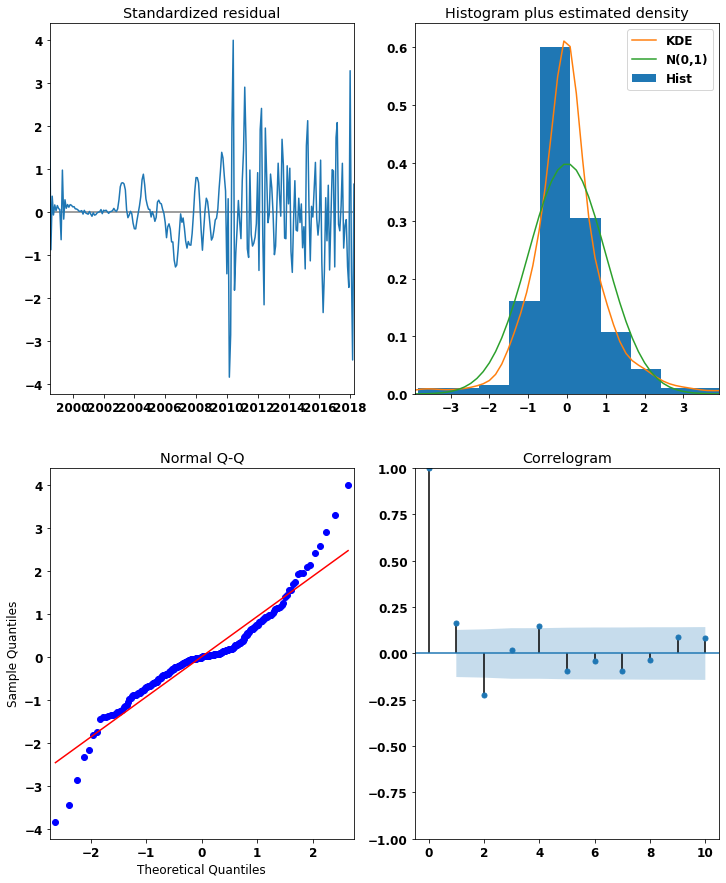

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11212


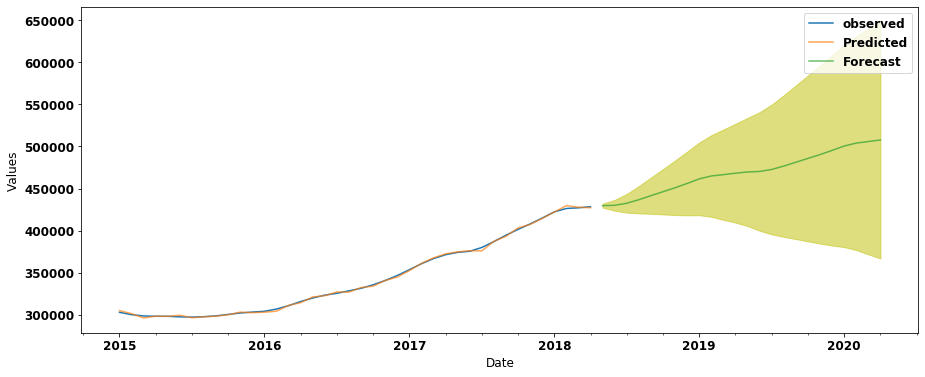

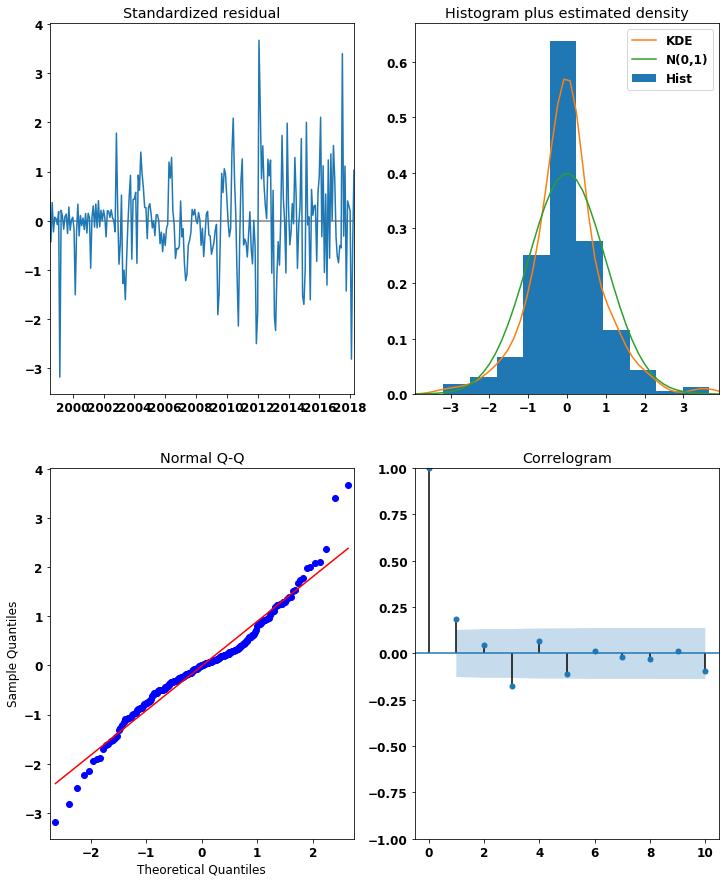

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11214


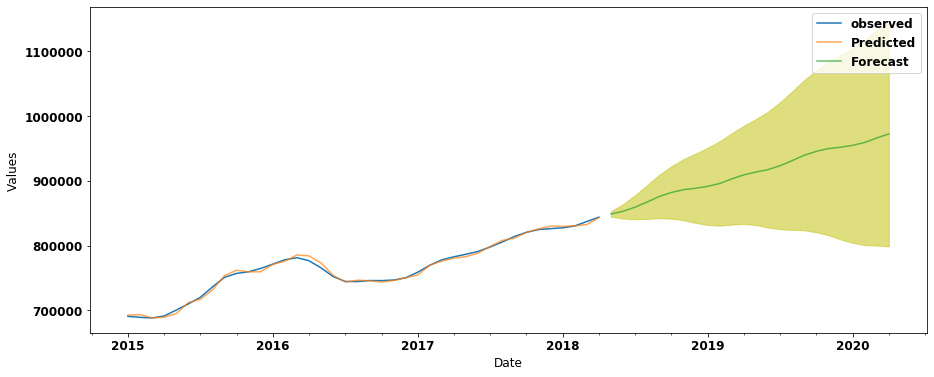

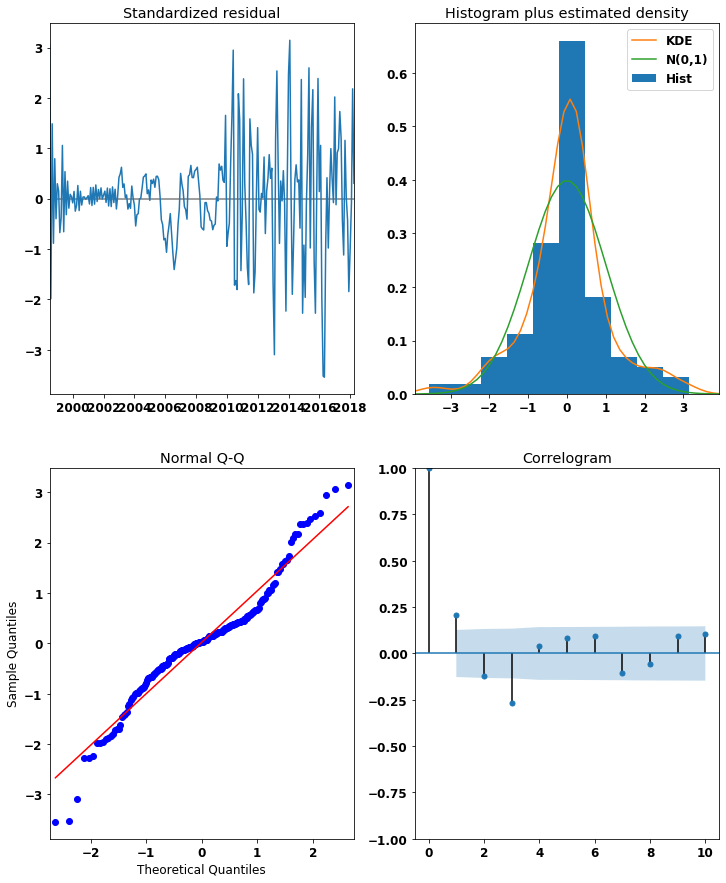

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11221


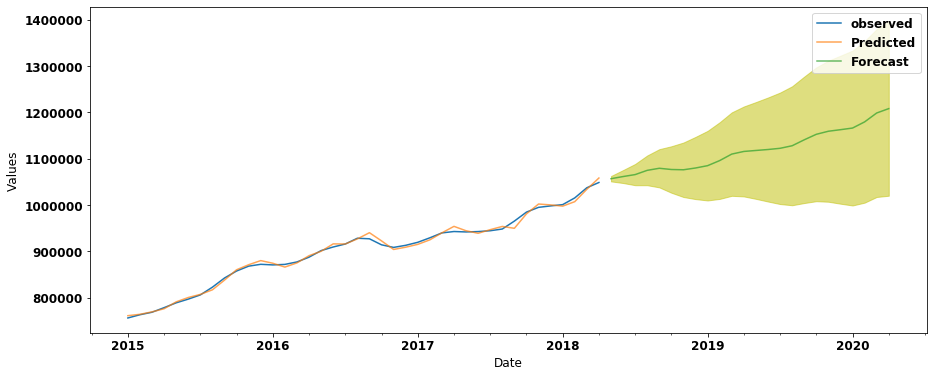

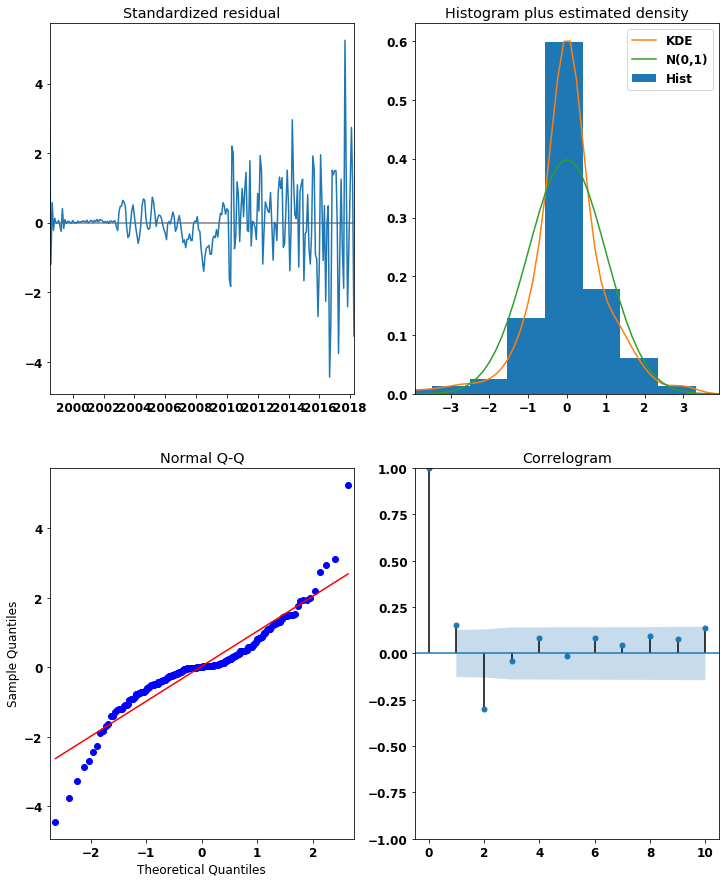

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11229


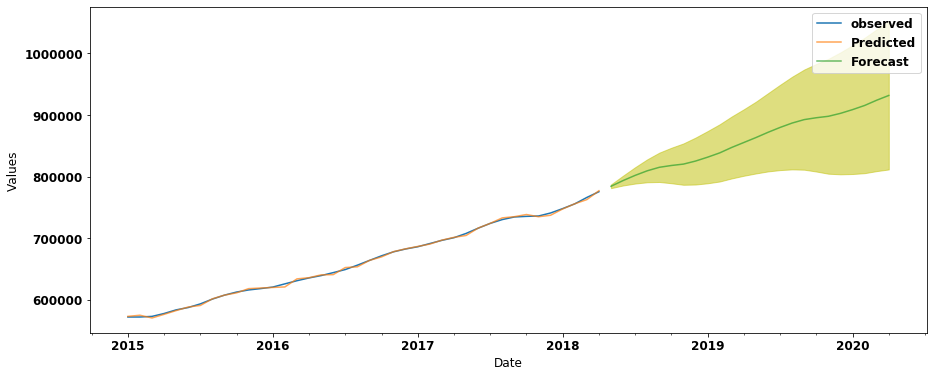

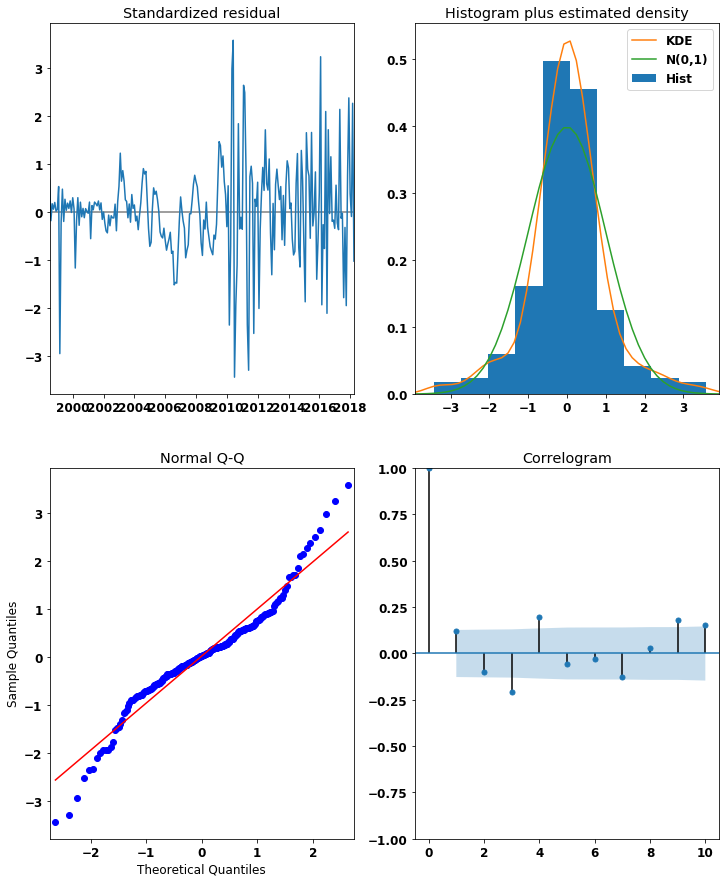

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11234


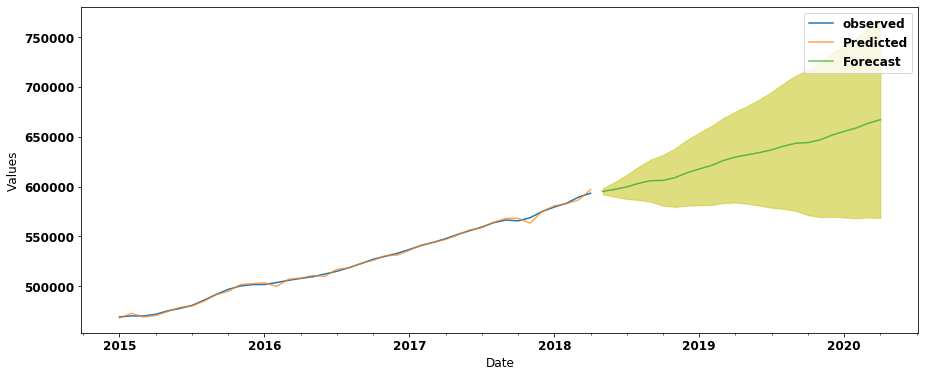

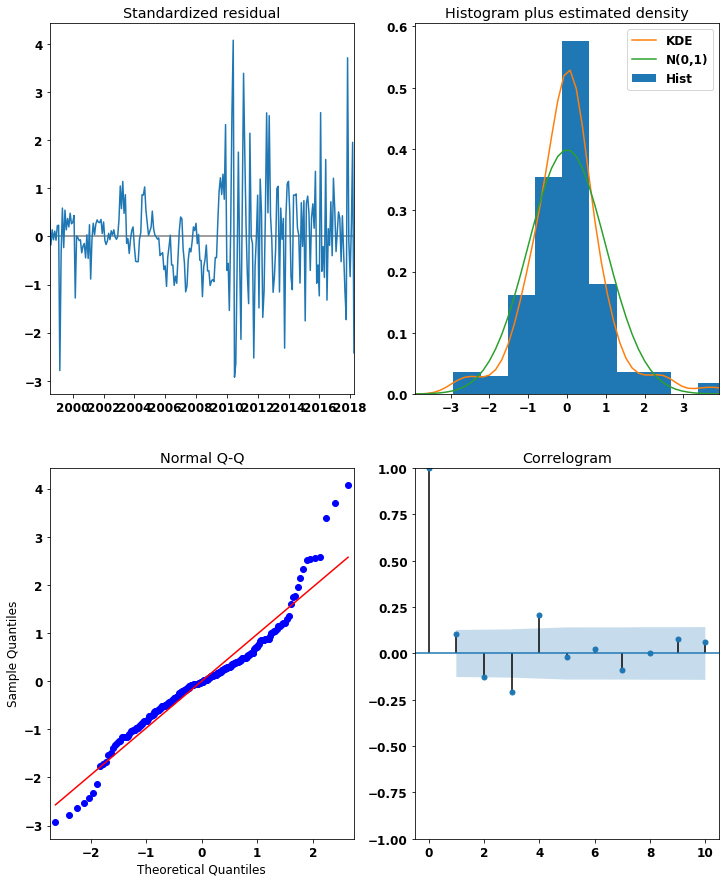

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11215


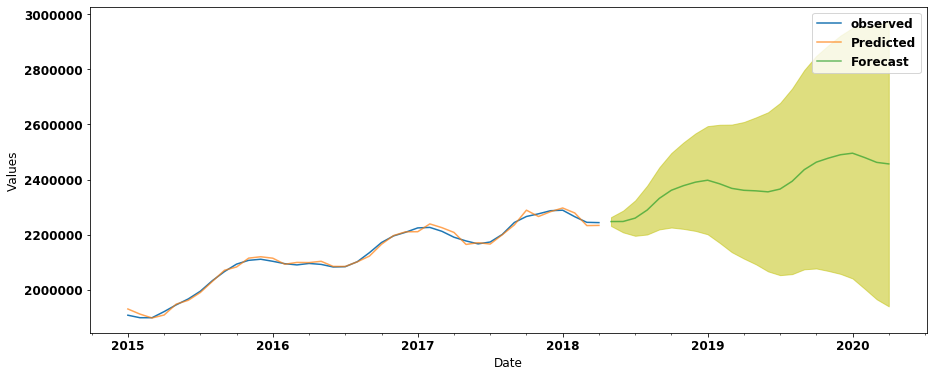

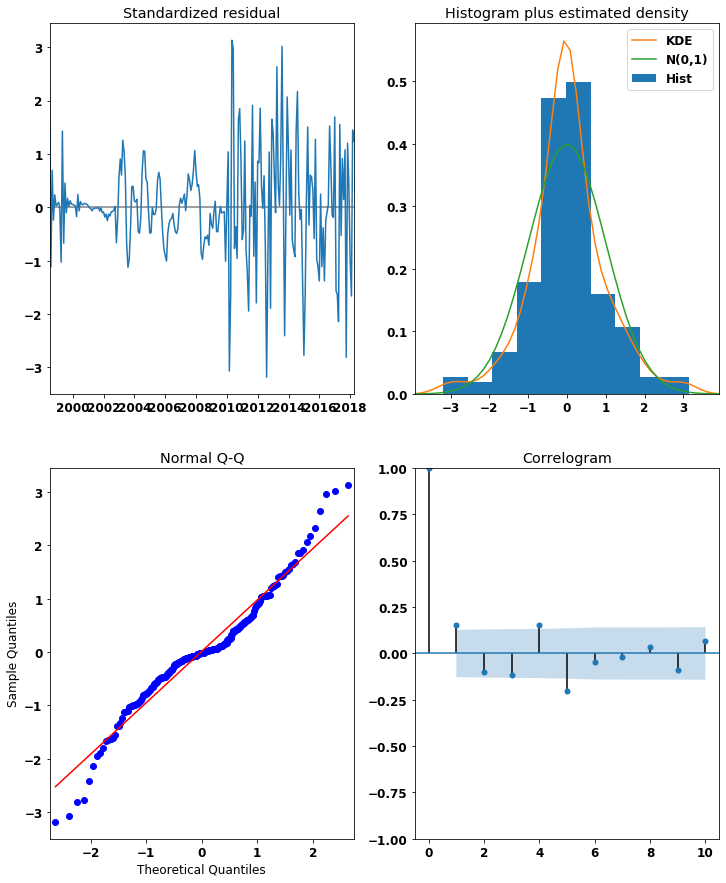

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11211


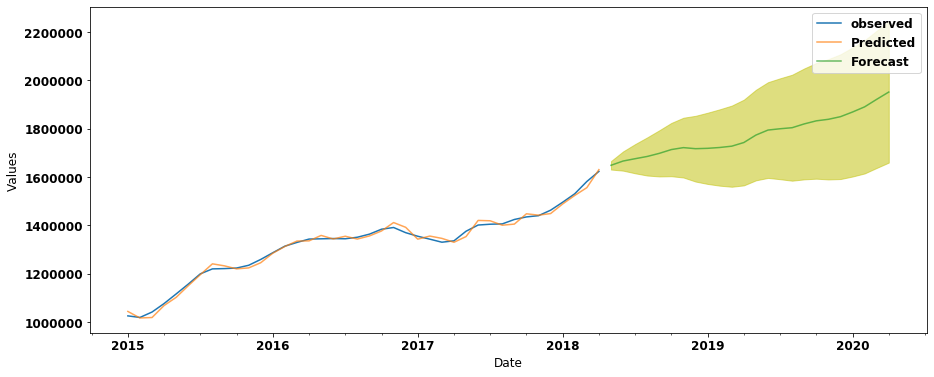

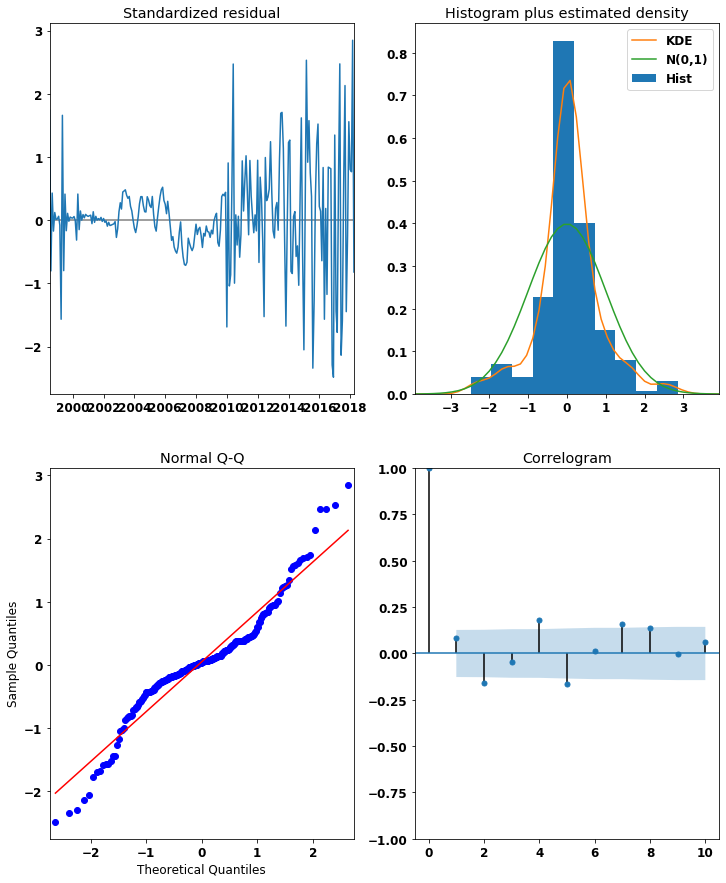

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11238


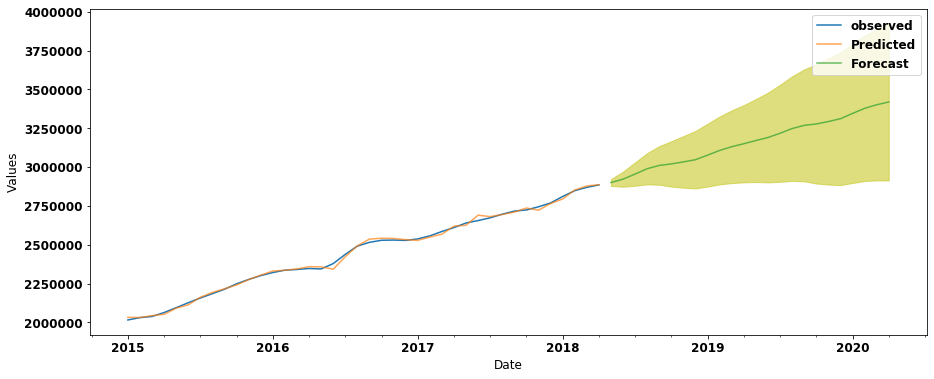

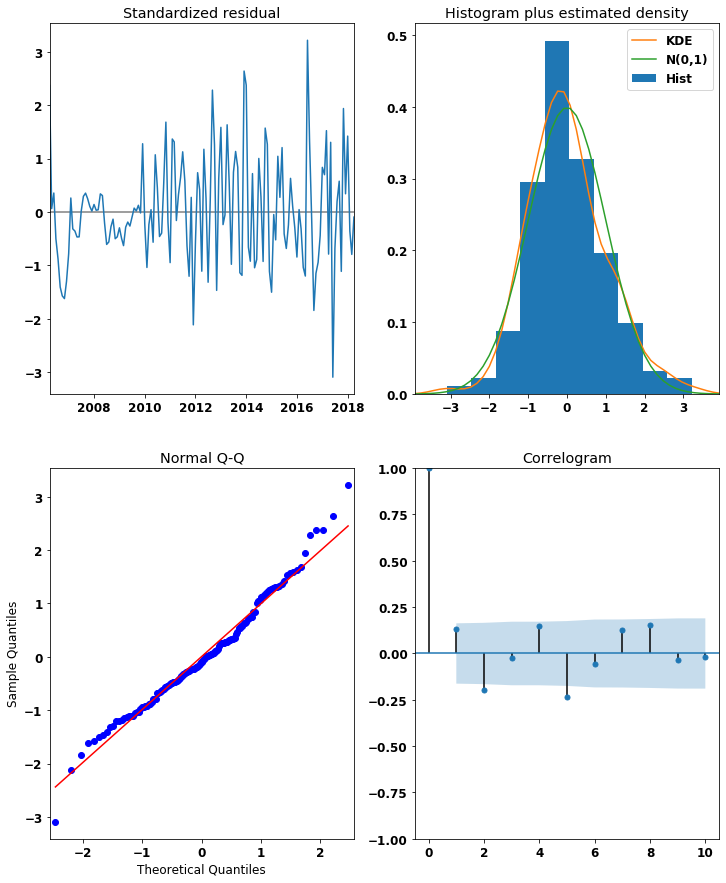

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11233


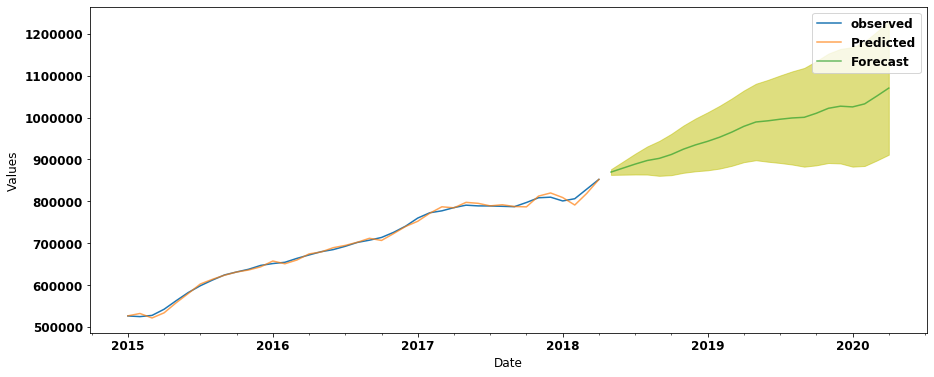

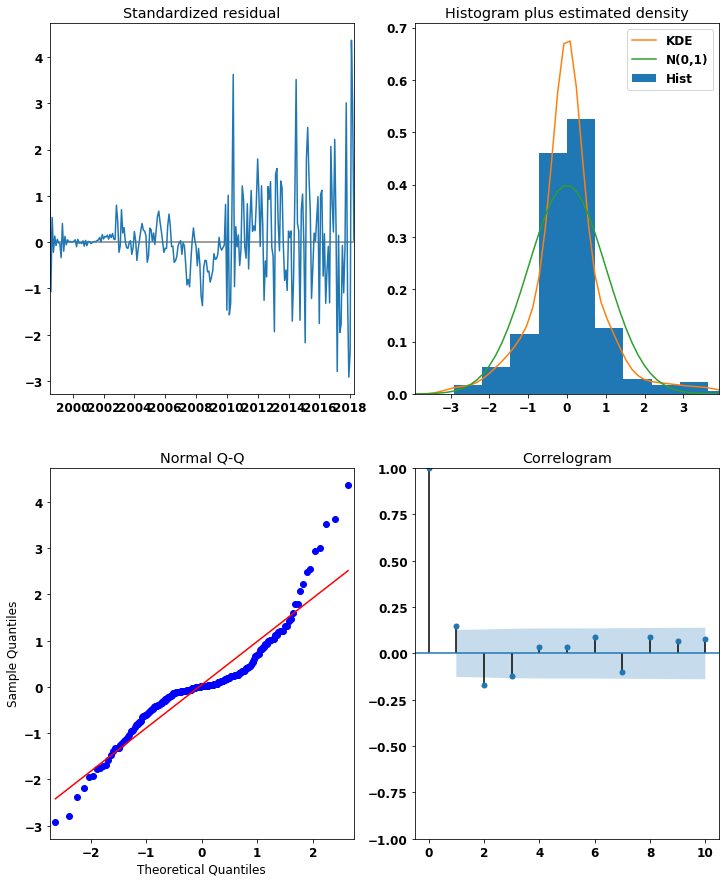

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11236


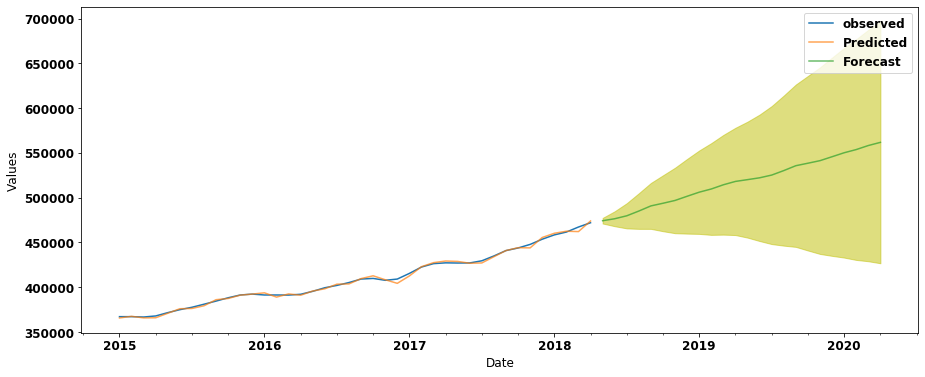

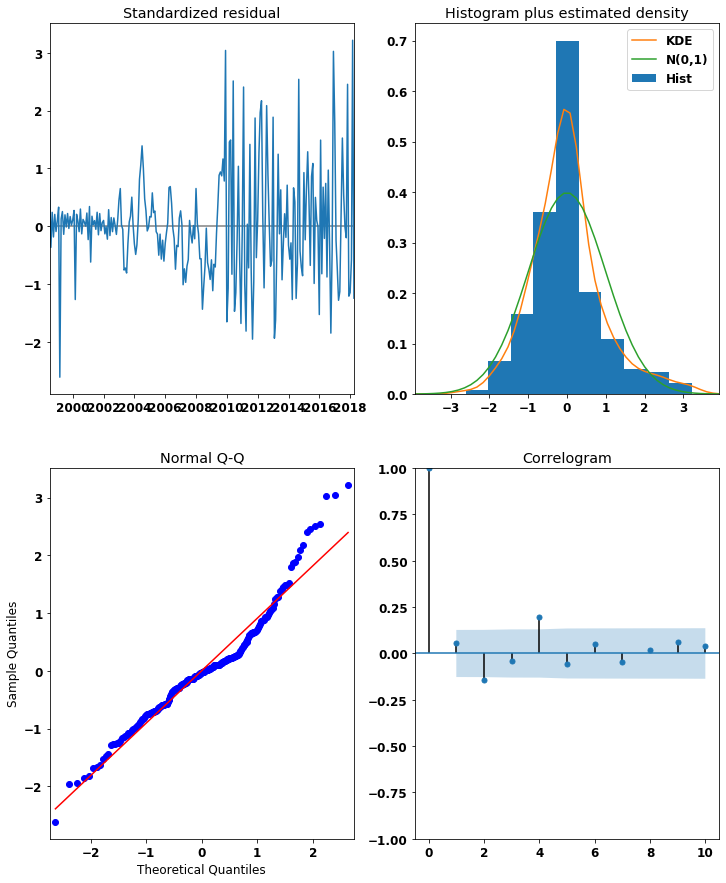

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11218


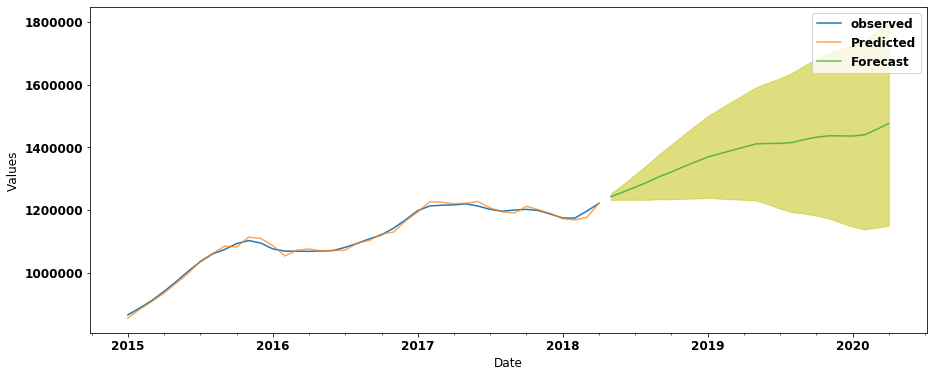

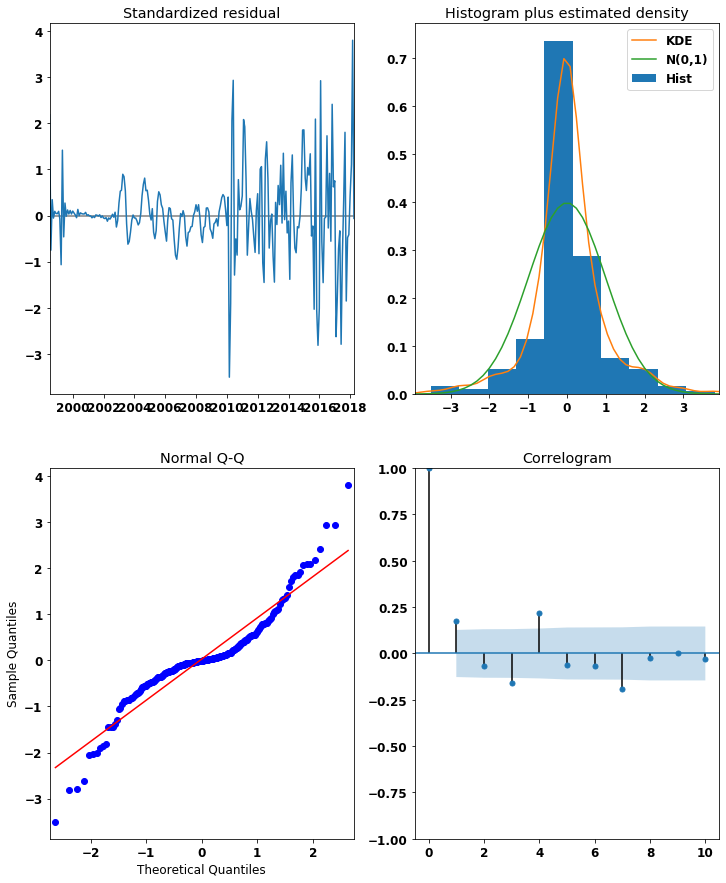

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11223


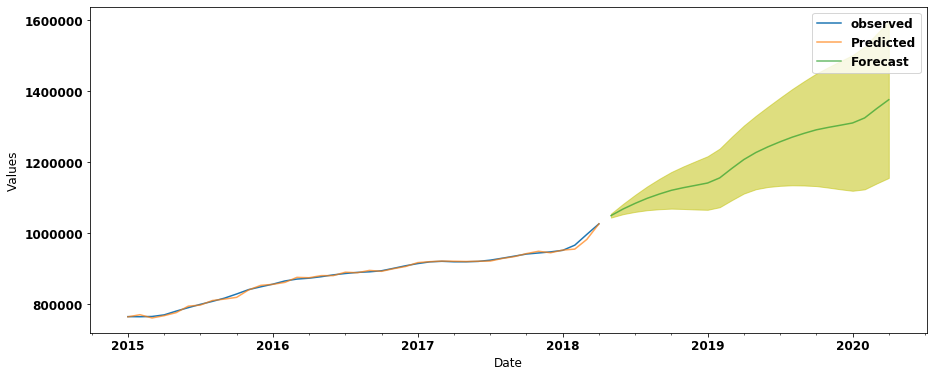

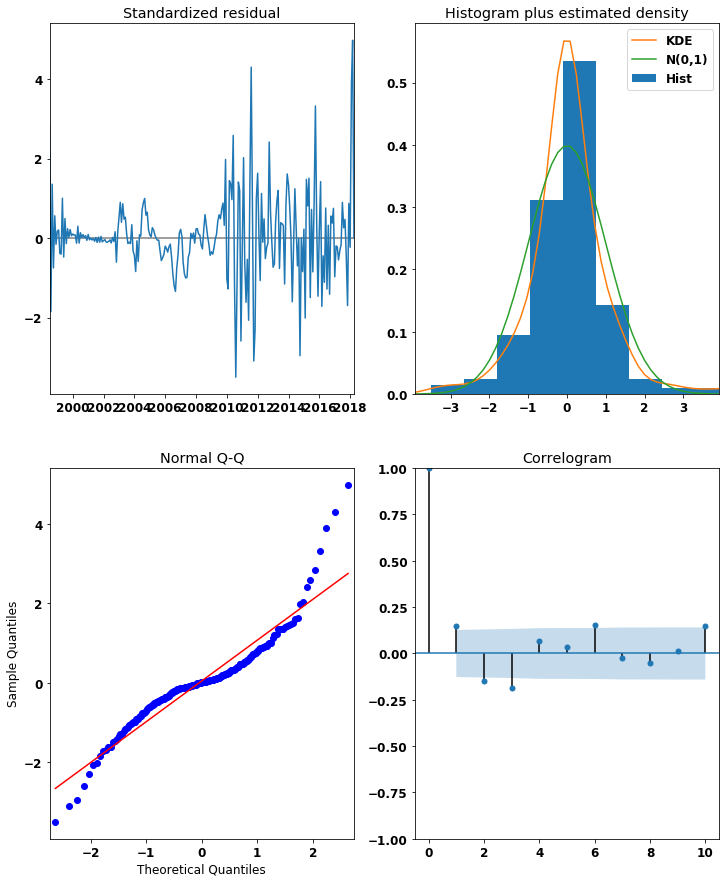

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11208


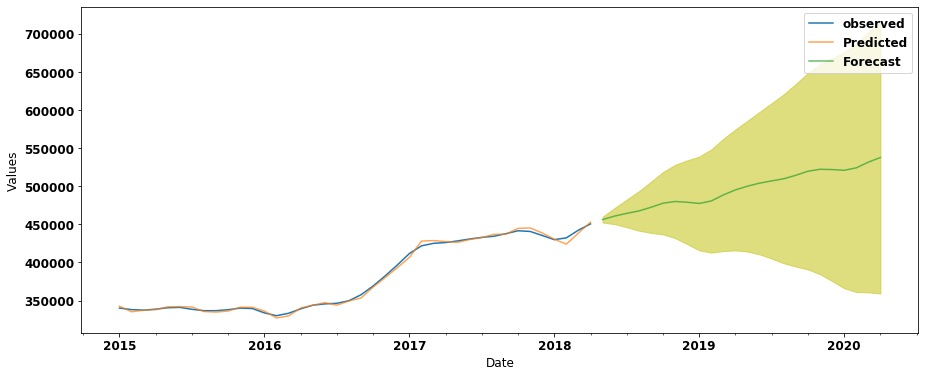

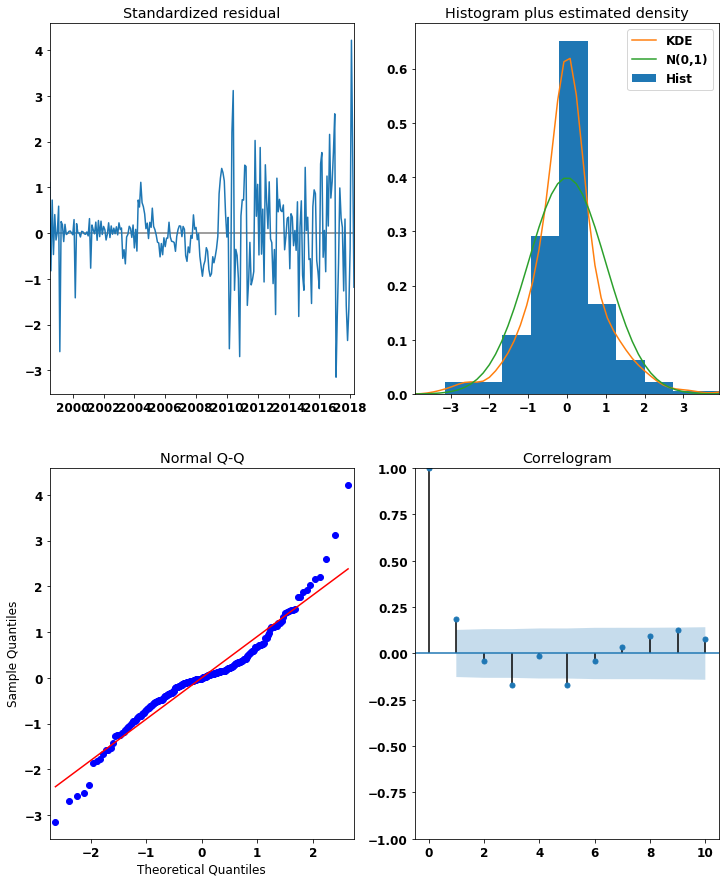

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11204


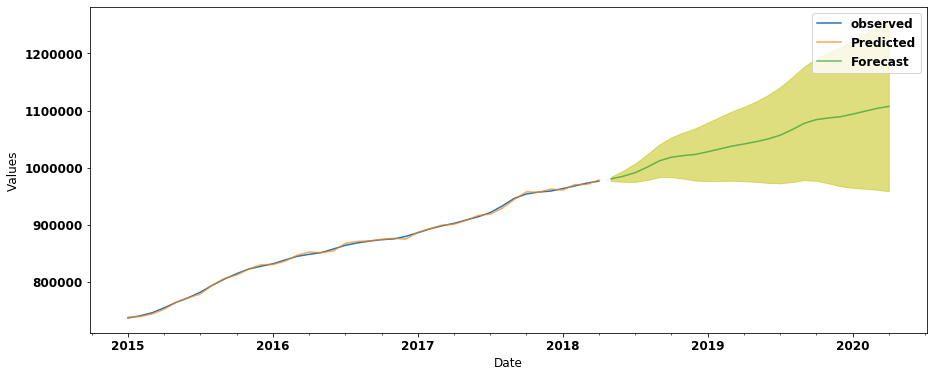

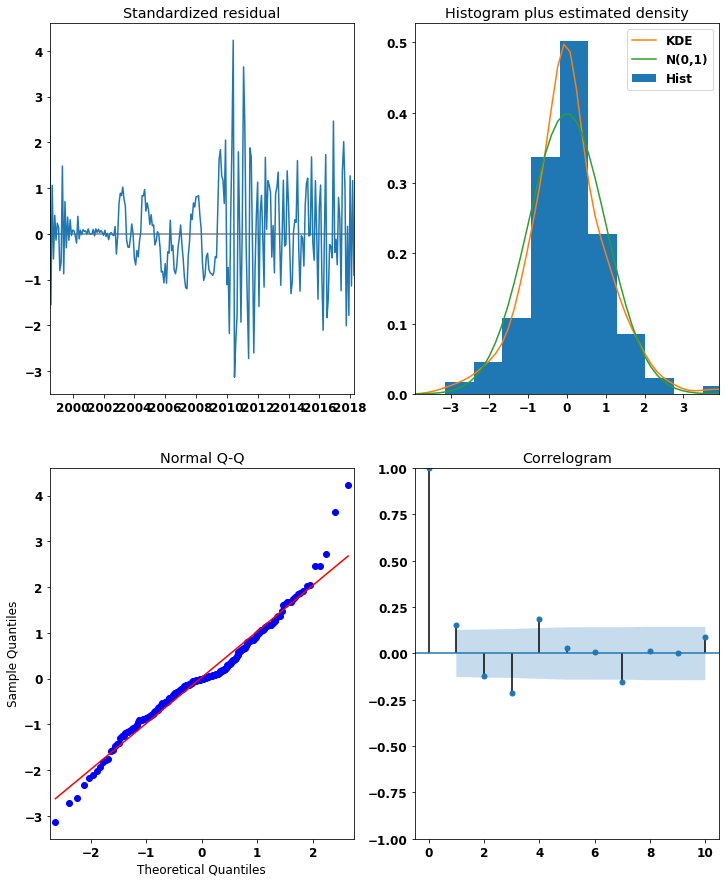

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11219


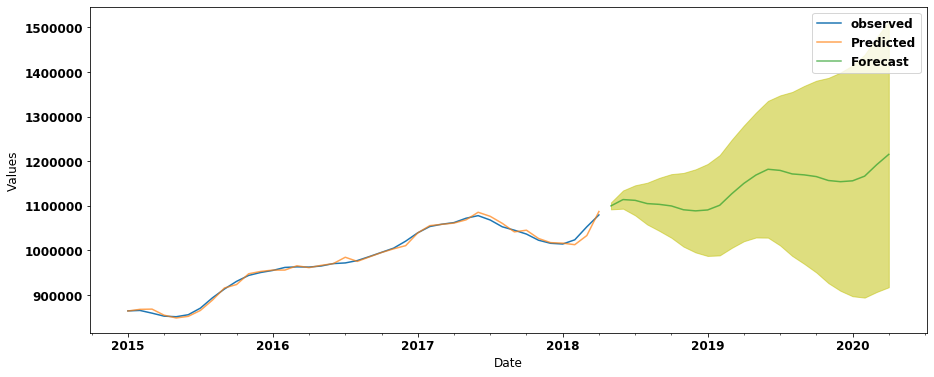

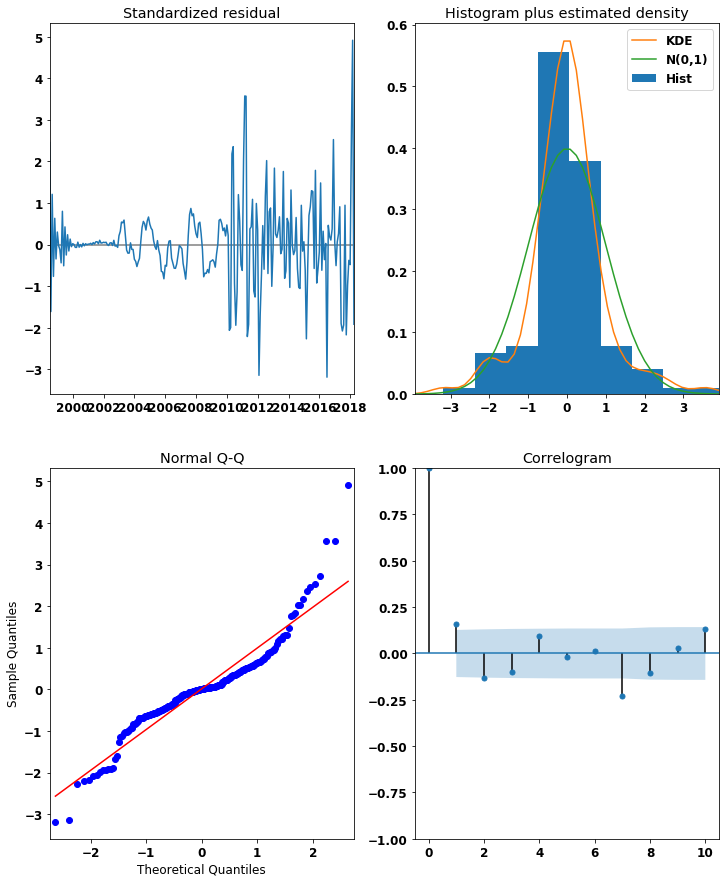

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11203


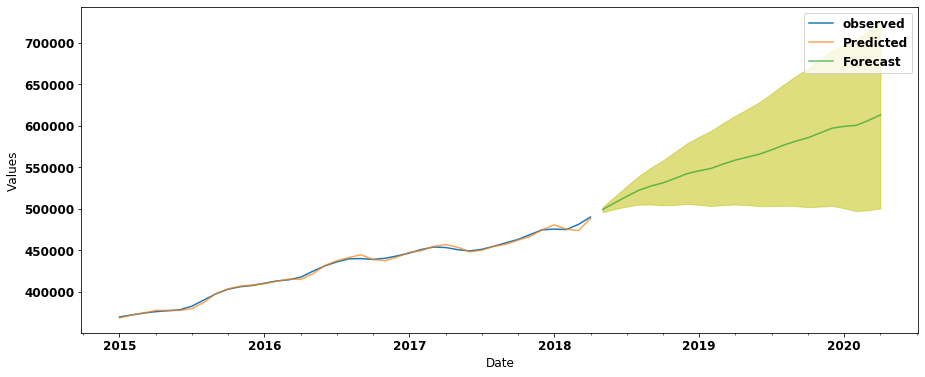

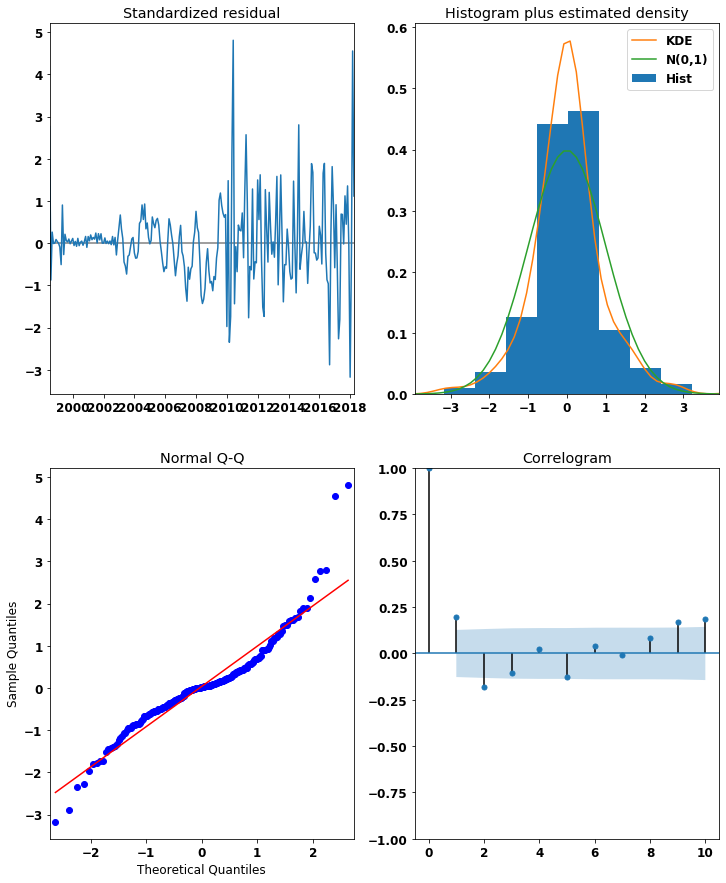

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11220


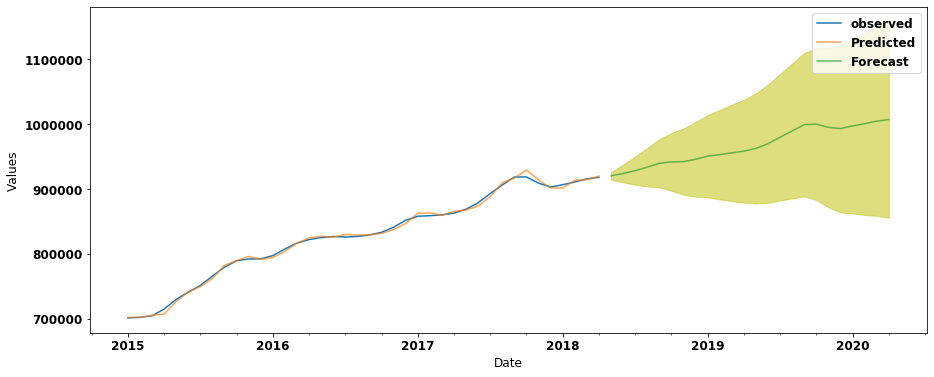

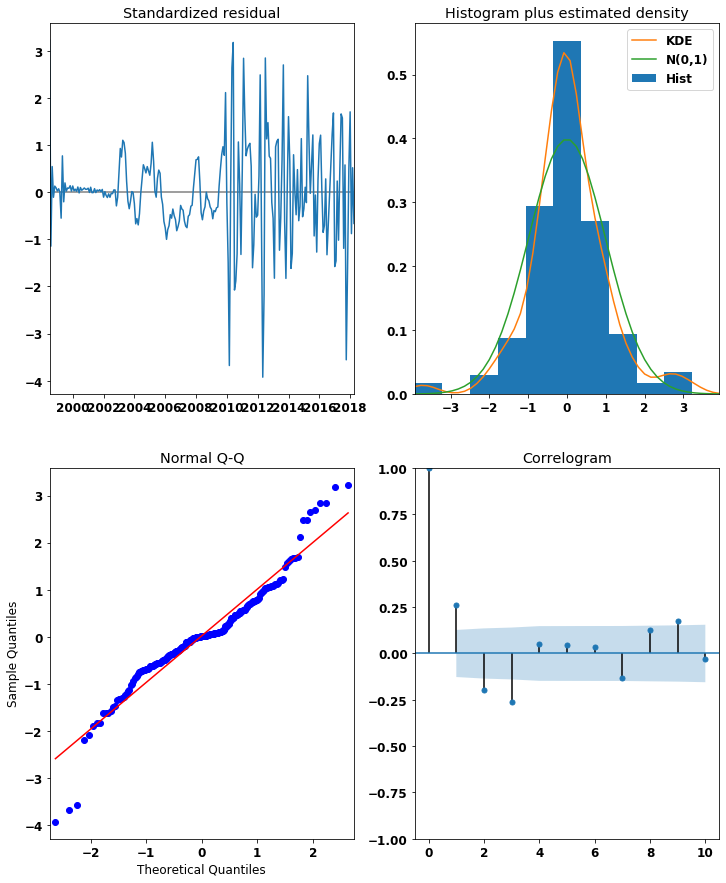

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11216


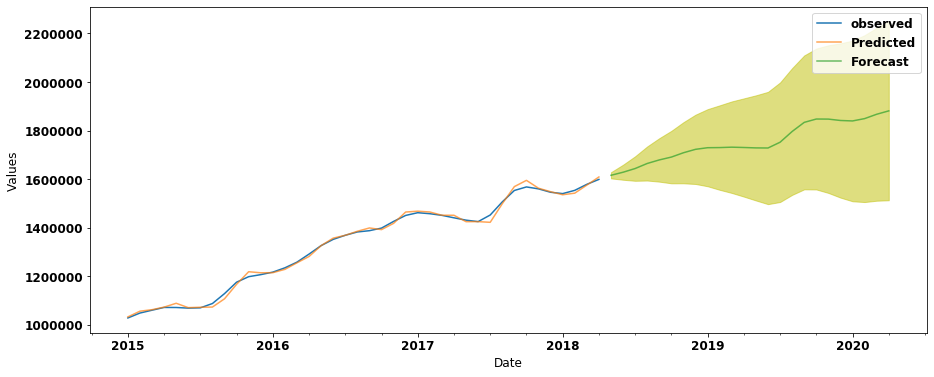

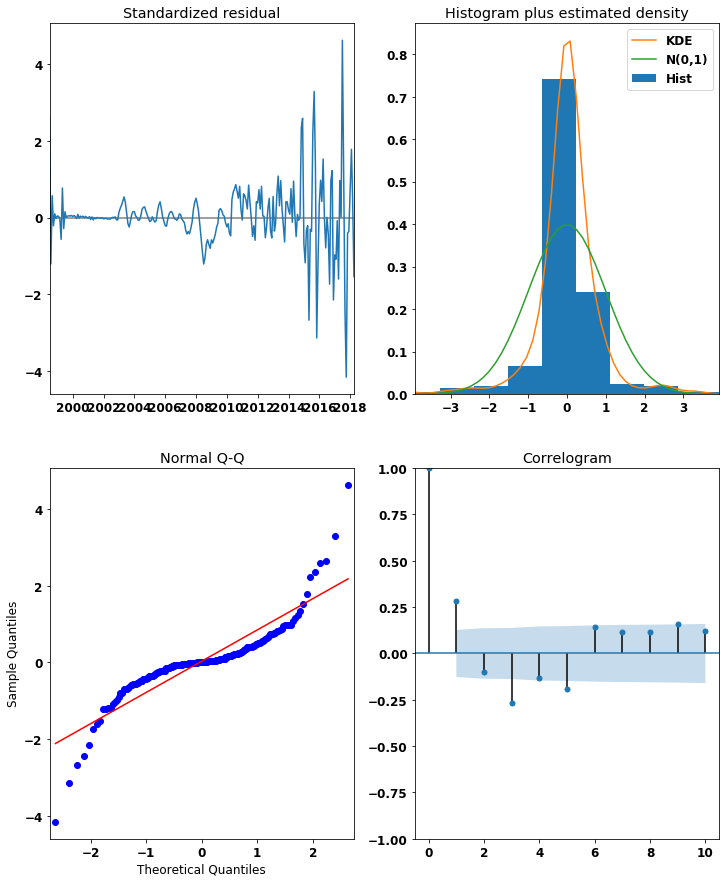

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11210


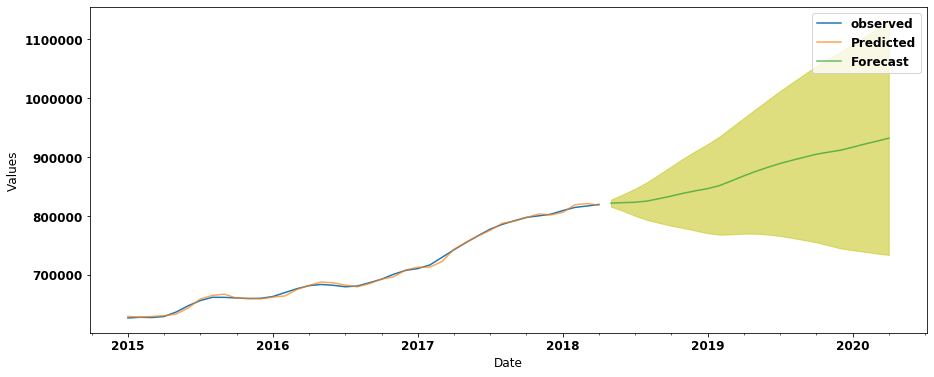

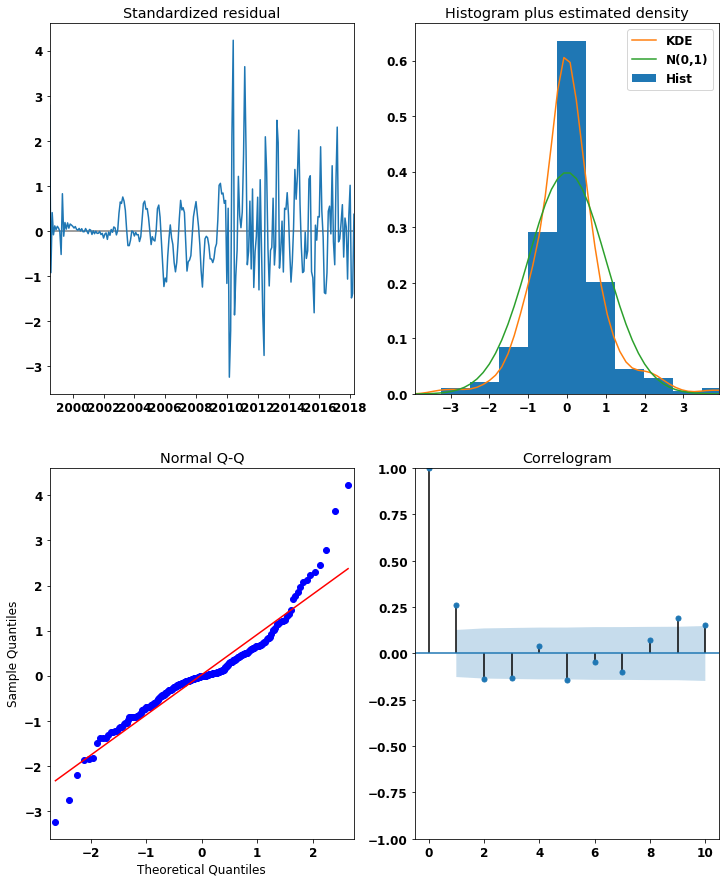

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11224


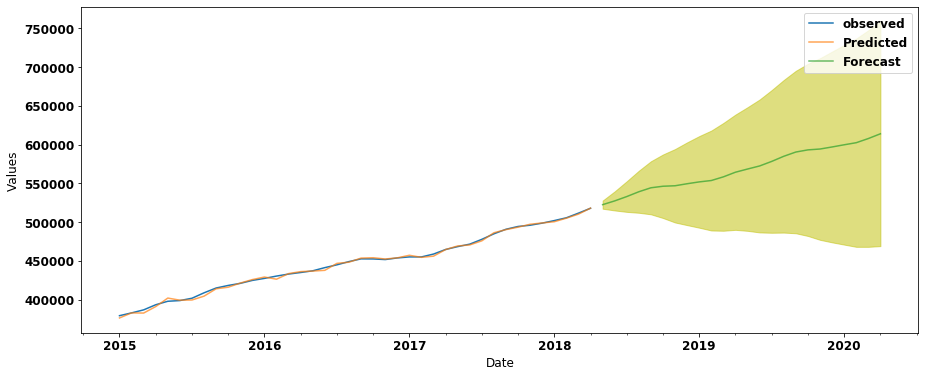

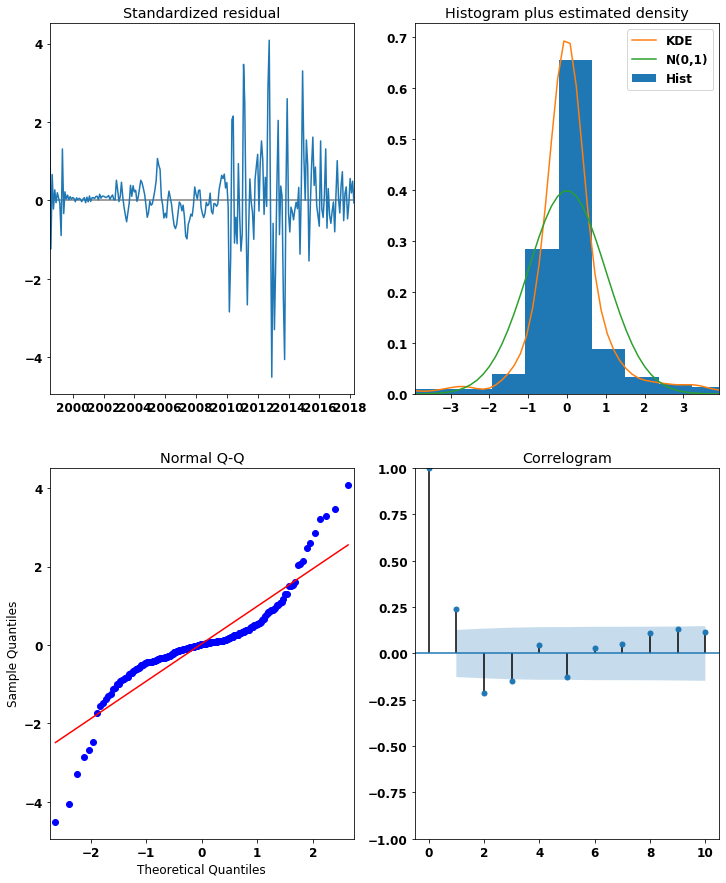

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11222


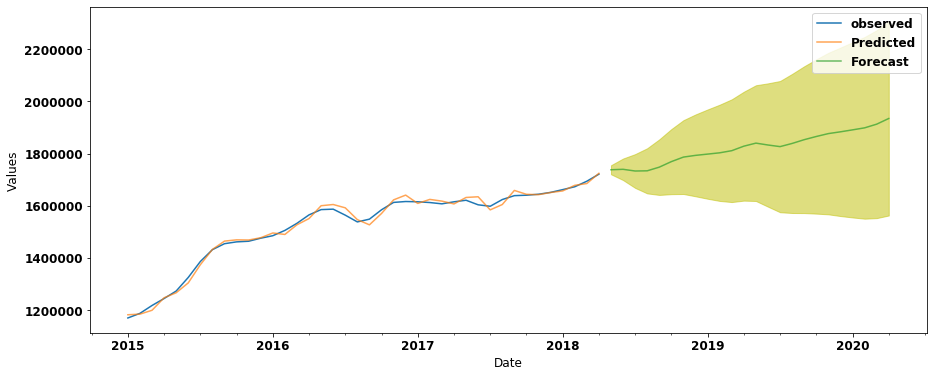

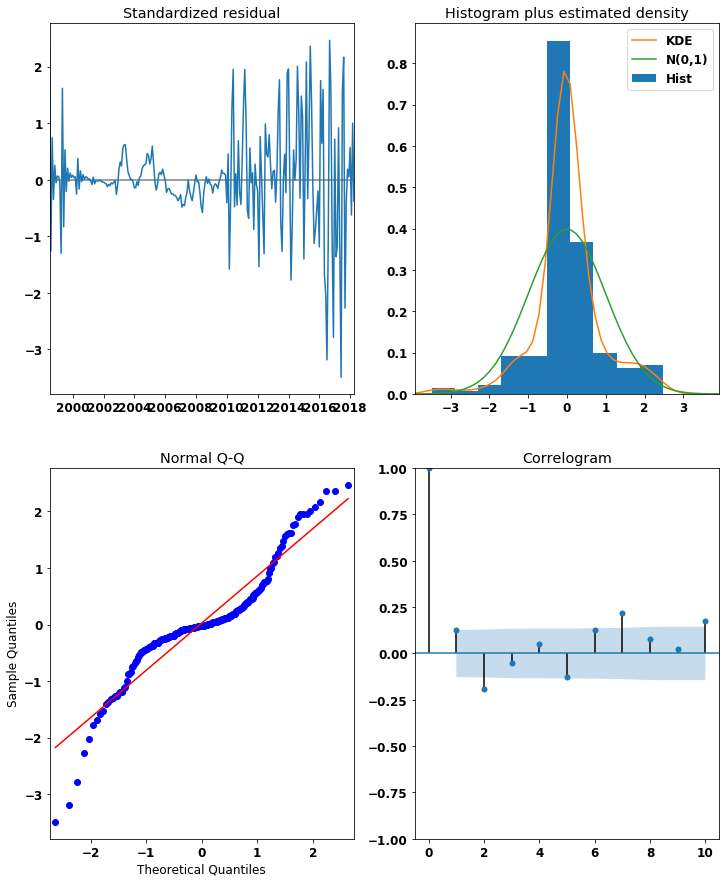

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11205


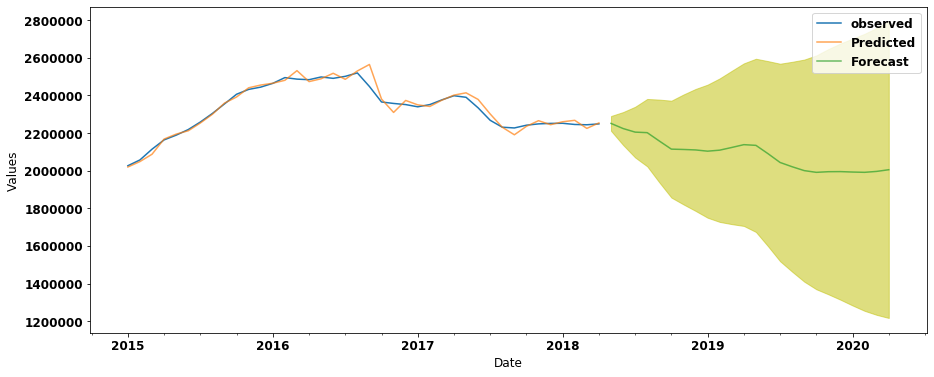

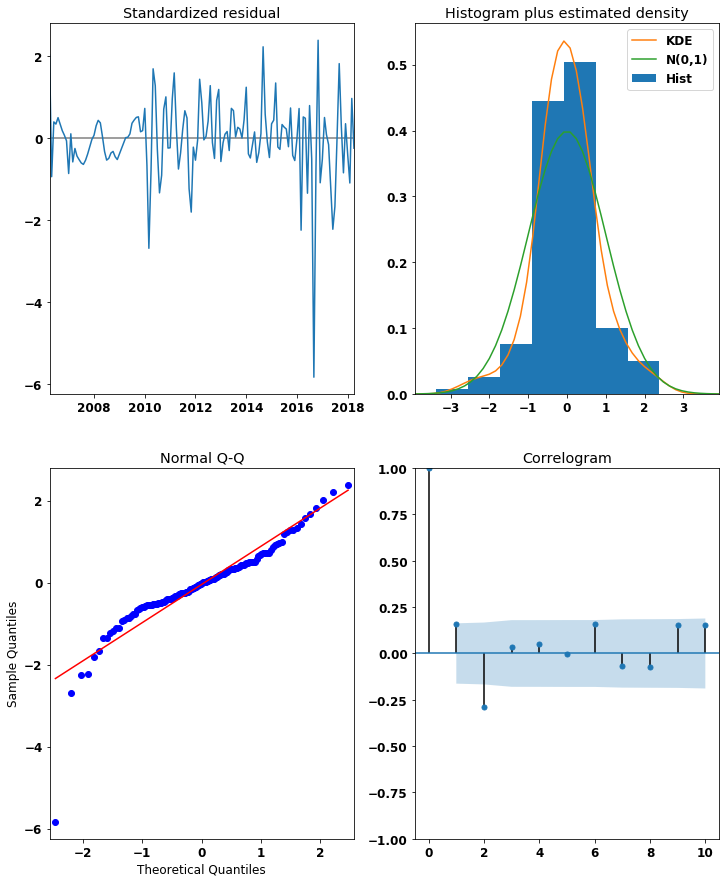

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11217


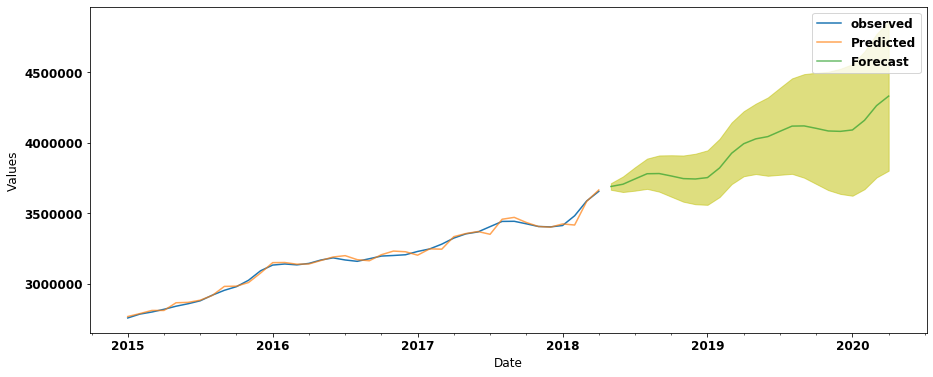

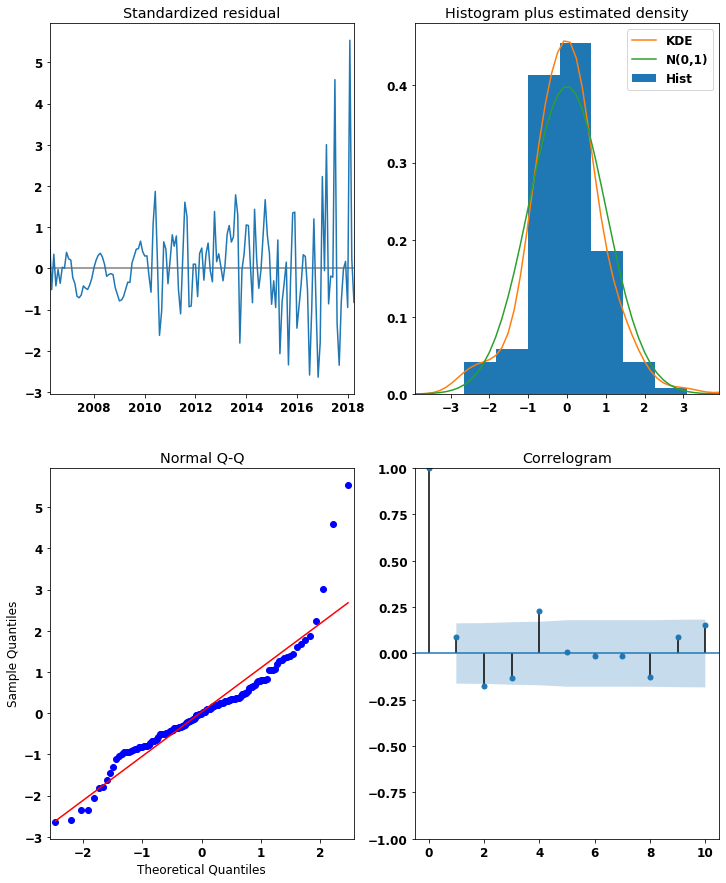

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


11228


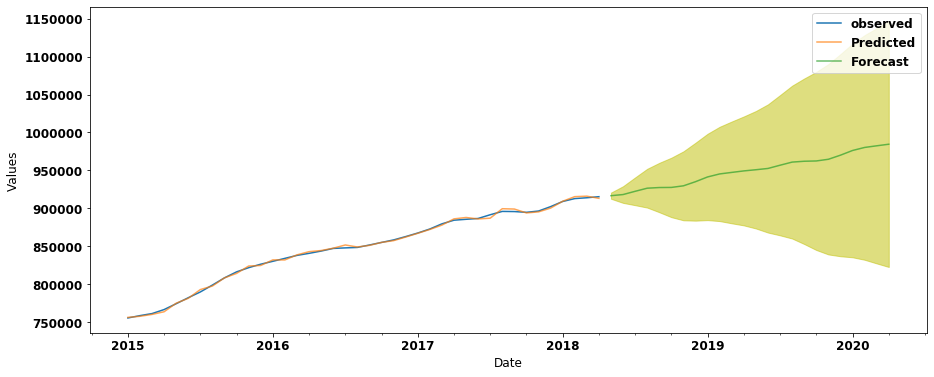

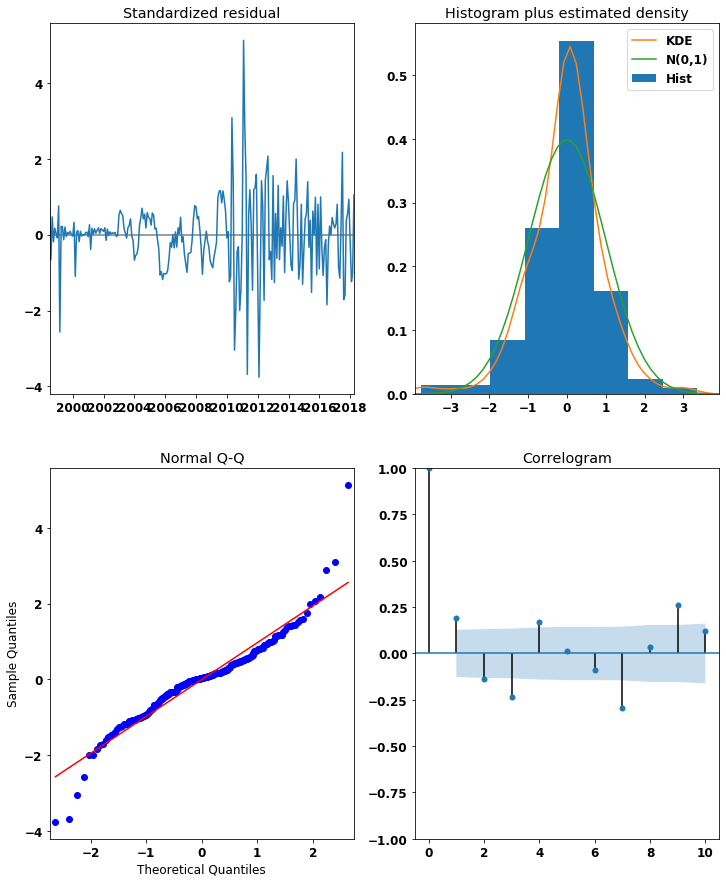

In [38]:
pred_df = pd.DataFrame()
known_RMSE = {}
forecast_2019_04 = {}
confid_min = {}
confid_max = {}
profit = {}
roi = {}
price_2018_04 = {}

for comb in best_combs:
    
    if comb[0] == 11238 or comb[0] == 11205 or comb[0] == 11217:
        
        df = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value.dropna()
        
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('2004-01-01'), dynamic=False)
        test_forecasted = pred.predicted_mean
        test_truth = test['2004-01-01':].value
        test_forecasted = test_forecasted['2004-01-01':]
    else:
        
        df = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value.dropna()
       
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('1996-04-01'), dynamic=False)
        test_forecasted = pred.predicted_mean
        test_truth = test['1996-04-01':].value
        test_forecasted = test_forecasted['1996-04-01':]
    error = mean_squared_error(test_forecasted, test_truth)
    known_RMSE[comb[0]] = np.sqrt(error)
    forecast = output.get_forecast(steps=24)
    forecast_2019_04[comb[0]] = forecast.predicted_mean['2019-04-01']
    pred_conf = forecast.conf_int()
    confid_min[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['lower value'][0]
    confid_max[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['upper value'][0]
    val_04_18 = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value[-1]
    profit[comb[0]] = forecast.predicted_mean['2019-04'] - val_04_18
    roi[comb[0]] = profit[comb[0]]/val_04_18
    price_2018_04[comb[0]] = val_04_18
    
    print(comb[0])
    make_pred_image(df, test_forecasted, forecast)
    output.plot_diagnostics(figsize=(12, 15))
    plt.show()
    
    

pred_df['zipcode'] = known_RMSE.keys()
pred_df['known_RMSE'] = known_RMSE.values()
pred_df['price_2018_04'] = price_2018_04.values()
pred_df['forecast_2019_04'] = forecast_2019_04.values()
pred_df['confid_min'] = confid_min.values()
pred_df['confid_max'] = confid_max.values()
pred_df['profit'] = profit.values()
pred_df['roi'] = roi.values()

Cleaning up how the data is displayed to make it easier to read in the dataframe

In [39]:
pred_df['roi'] = pred_df['roi'].apply(lambda x: round(x[0], 2))

In [40]:
pred_df['profit'] = pred_df['profit'].apply(lambda x: round(x[0]))

In [41]:
pred_df['price_2018_04'] = pred_df['price_2018_04'].apply(lambda x: round(x))

In [43]:
pred_df['forecast_2019_04'] = pred_df['forecast_2019_04'].apply(lambda x: round(x))

In [44]:
pred_df['known_RMSE'] = pred_df['known_RMSE'].apply(lambda x: round(x, 2))

In [45]:
pred_df['confid_min'] = pred_df['confid_min'].apply(lambda x: round(x))

In [46]:
pred_df['confid_max'] = pred_df['confid_max'].apply(lambda x: round(x))

In [47]:
pred_df['max_loss'] = pred_df['price_2018_04'] - pred_df['confid_min']

In [48]:
pred_df['loi'] = (pred_df['price_2018_04'] - pred_df['confid_min'])/pred_df['price_2018_04']

In [49]:
pred_df.sort_values(by=['profit', 'roi'], ascending=False).head(10) 

zipcode  known_RMSE  price_2018_04  forecast_2019_04  confid_min  \
26    11217  1521436.91        3656000           3993781     3763289   
11    11238  1037430.85        2885300           3150566     2901680   
2     11230   195286.09        1195400           1394810     1293215   
15    11223   105761.42        1026600           1207442     1111869   
14    11218   160910.85        1220900           1400089     1232303   
0     11226    14298.96         963200           1122250     1006179   
21    11216   224496.45        1598700           1730183     1527832   
12    11233   108914.16         852300            978919      893376   
10    11211   239293.03        1623700           1743199     1565822   
9     11215   733800.13        2243900           2361089     2113514   

    confid_max  profit   roi  max_loss       loi  
26     4224274  337781  0.09   -107289 -0.029346  
11     3399451  265266  0.09    -16380 -0.005677  
2      1496404  199410  0.17    -97815 -0.081826  
15     1303016  180842  0.18    -85269 -0.083060  
14     1567875  179189  0.15    -11403 -0.009340  
0      1238322  159050  0.17    -42979 -0.044621  
21     1932533  131483  0.08     70868  0.044329  
12     1064462  126619  0.15    -41076 -0.048194  
10     1920577  119499  0.07     57878  0.035646  
9      2608664  117189  0.05    130386  0.058107

In [50]:
pred_df.sort_values(by=['roi', 'profit'], ascending=False).head(10)

zipcode  known_RMSE  price_2018_04  forecast_2019_04  confid_min  \
15    11223   105761.42        1026600           1207442     1111869   
2     11230   195286.09        1195400           1394810     1293215   
0     11226    14298.96         963200           1122250     1006179   
14    11218   160910.85        1220900           1400089     1232303   
12    11233   108914.16         852300            978919      893376   
19    11203   189879.20         489900            558584      505000   
7     11229    73205.69         775500            855364      801414   
13    11236   190232.89         472000            518145      458230   
16    11208   223893.27         450600            495224      415767   
26    11217  1521436.91        3656000           3993781     3763289   

    confid_max  profit   roi  max_loss       loi  
15     1303016  180842  0.18    -85269 -0.083060  
2      1496404  199410  0.17    -97815 -0.081826  
0      1238322  159050  0.17    -42979 -0.044621  
14     1567875  179189  0.15    -11403 -0.009340  
12     1064462  126619  0.15    -41076 -0.048194  
19      612168   68684  0.14    -15100 -0.030823  
7       909315   79864  0.10    -25914 -0.033416  
13      578059   46145  0.10     13770  0.029174  
16      574681   44624  0.10     34833  0.077304  
26     4224274  337781  0.09   -107289 -0.029346

In [51]:
profit_zip = set(list(pred_df.sort_values(by=['roi', 'profit'], ascending=False).head(10).zipcode))
profit_zip

{11203, 11208, 11217, 11218, 11223, 11226, 11229, 11230, 11233, 11236}

In [52]:
roi_zip = set(list(pred_df.sort_values(by=['profit', 'roi'], ascending=False).head(10).zipcode))
roi_zip

{11211, 11215, 11216, 11217, 11218, 11223, 11226, 11230, 11233, 11238}

In [53]:
best_zips = list(profit_zip & roi_zip)
print(best_zips)

[11233, 11217, 11218, 11223, 11226, 11230]


In [54]:
pred_df[pred_df['zipcode'].isin(best_zips)]

zipcode  known_RMSE  price_2018_04  forecast_2019_04  confid_min  \
0     11226    14298.96         963200           1122250     1006179   
2     11230   195286.09        1195400           1394810     1293215   
12    11233   108914.16         852300            978919      893376   
14    11218   160910.85        1220900           1400089     1232303   
15    11223   105761.42        1026600           1207442     1111869   
26    11217  1521436.91        3656000           3993781     3763289   

    confid_max  profit   roi  max_loss       loi  
0      1238322  159050  0.17    -42979 -0.044621  
2      1496404  199410  0.17    -97815 -0.081826  
12     1064462  126619  0.15    -41076 -0.048194  
14     1567875  179189  0.15    -11403 -0.009340  
15     1303016  180842  0.18    -85269 -0.083060  
26     4224274  337781  0.09   -107289 -0.029346

# Step 5: Interpreting Results

These are the best 6 zipcodes for Kings County, NY.  
On any of them, based on our projections, there is no possibilty of a loss and the gain is high, both by profit and by return on investment.  

In [55]:
pred_df[pred_df['zipcode'].isin(best_zips)]

zipcode  known_RMSE  price_2018_04  forecast_2019_04  confid_min  \
0     11226    14298.96         963200           1122250     1006179   
2     11230   195286.09        1195400           1394810     1293215   
12    11233   108914.16         852300            978919      893376   
14    11218   160910.85        1220900           1400089     1232303   
15    11223   105761.42        1026600           1207442     1111869   
26    11217  1521436.91        3656000           3993781     3763289   

    confid_max  profit   roi  max_loss       loi  
0      1238322  159050  0.17    -42979 -0.044621  
2      1496404  199410  0.17    -97815 -0.081826  
12     1064462  126619  0.15    -41076 -0.048194  
14     1567875  179189  0.15    -11403 -0.009340  
15     1303016  180842  0.18    -85269 -0.083060  
26     4224274  337781  0.09   -107289 -0.029346

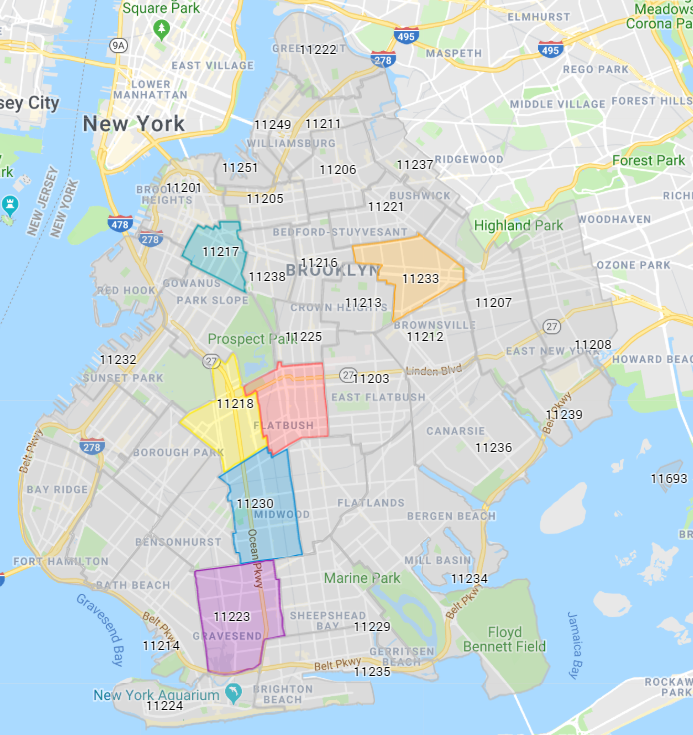